In [314]:
!pip install yfinance pandas_datareader matplotlib numpy

# **Credit Risk Assessment of Ford Motor Company**  
## **Estimating Default Probabilities Using Structural Credit Risk Models**

This report presents a quantitative assessment of **Ford Motor Company’s credit risk** through the lens of structural credit risk modeling. The analysis focuses on estimating the firm's **Probability of Default (PD)** over time using a range of established structural models — from the foundational **Merton model** to more refined frameworks such as **CreditGrades** and the **Hull et al. (2004)** model.

Unlike traditional credit ratings or subjective analyst assessments, structural models quantify default risk based on a firm's **market performance and balance sheet fundamentals**. They treat equity as a contingent claim on firm assets, enabling a more market-responsive measure of creditworthiness.

The analysis covers a **five-year period**, drawing on a comprehensive dataset of real-world financial and market variables, including:  
- Market capitalization  
- Equity volatility (historical and implied)  
- Book value of debt  
- Risk-free interest rate  
- Additional firm-specific indicators

**The primary objective** is to examine how Ford’s perceived credit risk has evolved across different economic environments and to critically compare the **sensitivity, assumptions, and limitations** of each modeling approach. This allows for a more nuanced understanding of the firm’s financial resilience and default potential from a structural modeling perspective.

In [316]:
# Import key libraries for data processing and visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
import pickle
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

# Set plot style and number format for cleaner outputs
plt.style.use("ggplot")
pd.set_option("display.float_format", "{:.2f}".format)

### **Defining the Analysis Period and Data Structure**

In this section, we load a pre-processed dataset containing **Ford Motor Company’s financial and market indicators**. Instead of relying on dynamic API calls, the data is sourced from a structured Excel file to ensure consistent formatting and full control over input variables.

Key preprocessing steps include:
- Importing the `.xlsx` file with both monthly and quarterly observations  
- Converting the `Date` column into datetime format  
- Setting `Date` as the time-series index  
- Sorting the index in chronological order  
- Removing duplicate entries (often present in Excel exports)

The resulting dataset forms a **clean, monthly time series** that spans from **July 2020 through June 2025**, enabling robust temporal modeling.

### **Key Variables**

The dataset incorporates essential inputs for structural credit risk modeling, including:
- **Book Value of Debt**  
- **Book Value of Equity**  
- **Market Capitalization**  
- **Risk-Free Interest Rate**  
- **Stock Price**  
- **Equity Volatility**

This refined data structure serves as a strong foundation for implementing and comparing multiple structural models of default probability.

In [318]:
# Load merged financial and market data from Excel
file_path = "ford_full_data_merged.xlsx"  # Update the path if necessary
df = pd.read_excel(file_path)

# Convert 'Date' column to datetime and set as index
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Optional: sort index in case rows are out of order
df = df.sort_index()

# Optional: drop duplicated indices if any (can happen in Excel exports)
df = df[~df.index.duplicated()]

# Quick preview and range check
print(f"✅ Data successfully loaded. Date range: {df.index.min().date()} → {df.index.max().date()}")
display(df.head())

✅ Data successfully loaded. Date range: 2020-07-31 → 2025-06-30


,Book Debt,Book Equity,Equity Volatility,Market Cap,Risk-Free Rate,Stock Price,Implied Volatility_IV30
Date,,,,,,,
2020-07-31,101788000000.00,30855000000.00,NaN,20081073221.45,NaN,5.14,NaN
2020-08-31,101788000000.00,30855000000.00,NaN,20719051119.52,0.00,5.30,NaN
2020-09-30,106280000000.00,33161000000.00,NaN,20232972898.36,0.00,5.18,NaN
2020-10-31,93109000000.00,40862000000.00,NaN,23483615182.40,0.00,6.01,NaN
2020-11-30,93109000000.00,40862000000.00,NaN,27584897147.04,0.00,7.06,NaN


# **A. Overview and Descriptive Analysis**

This step lays the groundwork for structural credit risk modeling by examining the underlying financial and market variables. Before any model calibration, it is crucial to assess the **quality, completeness, and behavior** of the data to ensure valid and reliable outputs.

We focus on the following key inputs:

- **Stock Price** (monthly observations)  
- **Market Capitalization**  
- **Risk-Free Interest Rate**  
- **Equity Volatility**  
- **Book Value of Debt**  
- **Book Value of Equity**

These variables are derived from a merged dataset that integrates **automated API-based sources** with **manually compiled financial statements**, offering both breadth and historical accuracy.

### **Objectives of This Step**
- Validate the **integrity and internal consistency** of the dataset  
- Compute and review **basic descriptive statistics** (mean, standard deviation, min, max)  
- Detect any **missing values or structural anomalies**  
- Prepare the dataset for time series **visual inspection and diagnostics**

Understanding the **statistical profile** of each input is essential, as these metrics directly influence the estimation of Ford's default probability under various structural models.

> _In the next step, we will visualize these variables to uncover underlying trends, regime shifts, and outliers that could materially affect credit risk estimates._-


In [323]:
# Check key statistics (mean, std, min, max, quartiles)
summary_stats = df[["Stock Price", "Market Cap", "Equity Volatility", "Book Debt", "Book Equity", "Risk-Free Rate"]].describe().T
summary_stats["missing_values"] = df[summary_stats.index].isna().sum()
summary_stats["% missing"] = 100 * summary_stats["missing_values"] / len(df)
summary_stats.round(2)

,count,mean,std,min,25%,50%,75%,max,missing_values,% missing
Stock Price,60.00,10.41,2.21,5.14,9.44,10.58,11.26,16.24,0,0.00
Market Cap,60.00,40669947001.98,8624648012.91,20081073221.45,36868993406.00,41321654883.67,43980555719.57,63416634515.25,0,0.00
Equity Volatility,48.00,0.41,0.05,0.33,0.37,0.39,0.45,0.50,12,20.00
Book Debt,60.00,108693100000.00,29013776444.83,49805000000.00,89501000000.00,95905000000.00,149538833333.33,158522000000.00,0,0.00
Book Equity,60.00,43579816666.67,3287879600.75,30855000000.00,42870000000.00,43994833333.33,44671666666.67,48704000000.00,0,0.00
Risk-Free Rate,58.00,0.03,0.02,0.00,0.00,0.04,0.05,0.05,2,3.33


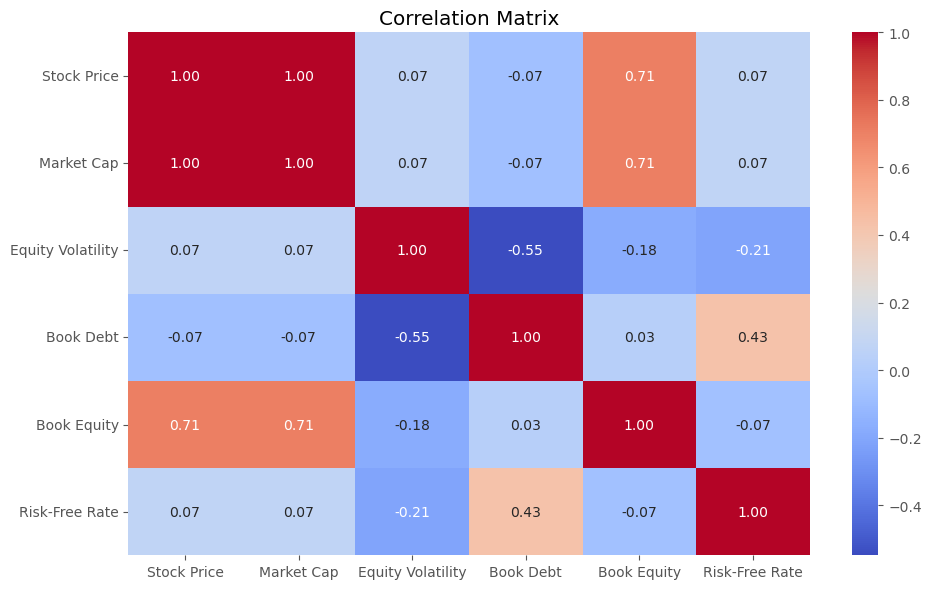

In [325]:
# Correlation matrix
df_corr = df[["Stock Price", "Market Cap", "Equity Volatility", "Book Debt", "Book Equity", "Risk-Free Rate"]].corr()
plt.figure(figsize=(10, 6))
plt.title("Correlation Matrix")
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.tight_layout()
plt.show()

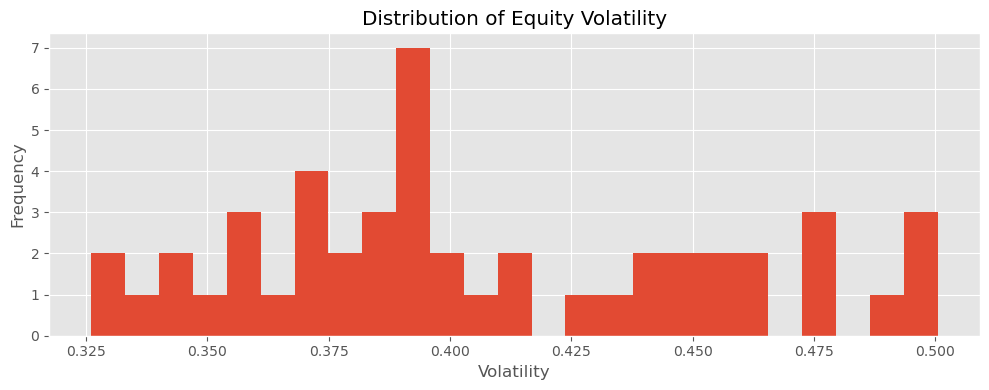

In [327]:
# Distribution of Equity Volatility
df["Equity Volatility"].hist(bins=25, figsize=(10, 4))
plt.title("Distribution of Equity Volatility")
plt.xlabel("Volatility")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Exploratory Data Analysis: Interpretation of Financial Variables**

This section presents the initial analytical exploration of Ford Motor Company’s key financial indicators. The goal is to evaluate statistical relationships and identify patterns or anomalies that could influence the firm's perceived credit risk.

---

### **Correlation Matrix Analysis**

The correlation matrix offers valuable insights into how financial variables interact with one another over the observed period:

- **Stock Price vs. Book Equity (correlation: 0.71)**  
  A strong positive relationship suggests that changes in Ford’s market value closely track its accounting equity base. This implies that investor sentiment is well aligned with fundamental book values, reinforcing confidence in market efficiency.

- **Equity Volatility vs. Book Debt (correlation: −0.55)**  
  This moderately negative correlation is noteworthy. While higher debt typically implies increased equity risk, the inverse relationship here may reflect periods in which Ford’s leverage increased amid stable or favorable operating conditions — possibly due to improved liquidity, government support, or long-term financing strategies.

- **Book Debt vs. Risk-Free Rate (correlation: 0.43)**  
  A moderate positive correlation suggests Ford’s debt issuance has been less constrained by rising rates. This could be driven by strategic refinancing, fixed-rate issuance preferences, or confidence in maintaining serviceability despite interest rate pressures.

- **Stock Price vs. Market Capitalization (correlation: 1.00)**  
  As expected, the perfect correlation confirms that market cap is a direct function of stock price multiplied by shares outstanding. This serves as a validation of data structure.

---

### **Equity Volatility Distribution**

The histogram of equity volatility reveals a tightly clustered distribution centered around **0.40**, with relatively limited dispersion:

- **Volatility Stability**  
  The narrow spread indicates consistent market-perceived risk around Ford's equity. Such stability is critical when calibrating models that rely on volatility inputs, especially those assuming lognormal asset dynamics.

- **Low Tail Risk Implication**  
  The absence of extreme volatility spikes suggests Ford did not experience sharp market-based distress during the analyzed period. This could translate into lower predicted default probabilities in risk models, assuming other factors remain constant.

---

### **Key Implications for Modeling**

These observed relationships directly impact how structural credit risk models will interpret Ford’s condition:

- The negative association between debt and equity volatility will affect the **Distance to Default** metric, particularly in CreditGrades and Merton models.
- The strong coupling of stock price and book equity supports the validity of using market data to reflect internal financial performance.
- The consistent volatility range helps justify the use of continuous-time diffusion models in forecasting default probability.

Together, these insights validate the structural modeling approach and establish a reliable base for scenario-based simulations in the upcoming sections.

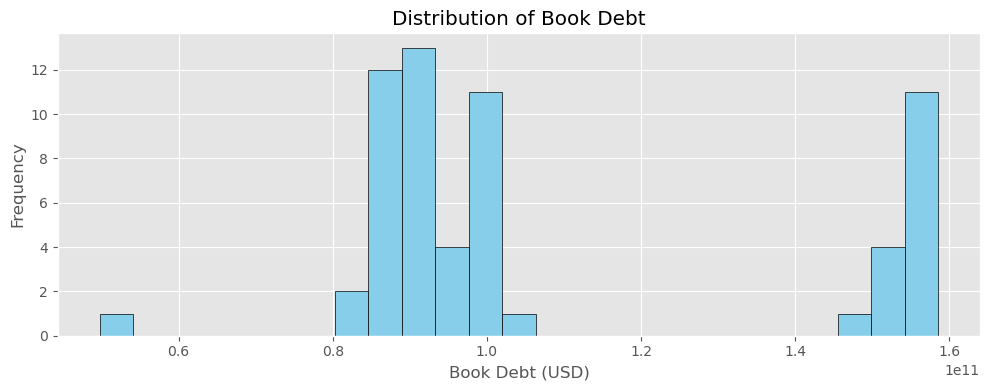

In [330]:
# Distribution of Book Debt
df["Book Debt"].dropna().hist(bins=25, figsize=(10, 4), color="skyblue", edgecolor="black")
plt.title("Distribution of Book Debt")
plt.xlabel("Book Debt (USD)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Distribution of Book Debt**

The histogram above illustrates the distribution of **Book Debt** recorded across the analysis period. The data reveals a distinctly **multi-modal pattern**, pointing to structural shifts in the company’s capital structure over time.

---

### **Key Observations**

- **Three distinct clusters** are evident:
  - A central concentration between approximately **$90–100 billion**, likely reflecting Ford’s average debt profile during the mid-phase of the observation window.
  - A higher cluster between **$150–160 billion**, which likely corresponds to more recent years — signaling a notable **increase in financial leverage**.
  - A smaller, lower cluster around **$50–60 billion**, possibly tied to earlier or outlier quarters at the beginning of the timeline.

- The distribution appears **broad but controlled**, with no extreme tail risk. This suggests that Ford’s increasing debt levels have been **deliberate and measured**, rather than reactive or disorderly.

---

### **Strategic and Modeling Implications**

- The upward trend in book debt indicates a likely shift in **capital structure strategy**, potentially driven by external conditions — such as rising interest rates, liquidity planning, or pandemic-era market responses.

- In structural models like **Merton** and **CreditGrades**, the **book value of debt serves as the default threshold**. If the estimated asset value falls below this level, the model triggers a default event.

- Therefore, rising debt — without a proportional increase in asset value or equity — compresses the **Distance to Default (DD)** and raises the **Probability of Default (PD)**.

This analysis reinforces the importance of monitoring **debt dynamics over time**, both in absolute terms and relative to firm value, as they have a direct and often nonlinear impact on structural credit risk outcomes.

# **B. Merton model (non-linear system) using historical volatility**

This section implements the **classic Merton model**, which estimates a firm’s probability of default (PD) by treating equity as a European call option on the firm’s assets. The model is solved using a **nonlinear system of equations** and employs **historical equity return volatility** as a key input.

---

### **Model Framework**

The firm's equity value is modeled as:

\$$
E = V \Phi(d_1) - e^{-rT} D \Phi(d_2)
$$

and the equity volatility is linked to asset volatility by:

\$$
\sigma_E = \frac{V}{E} \Phi(d_1) \cdot \sigma_V
$$

with:

\$$
d_1 = \frac{\ln(V/D) + (r + 0.5 \sigma_V^2) T}{\sigma_V \sqrt{T}}, \quad d_2 = d_1 - \sigma_V \sqrt{T}
\$$

Once the system is solved for \( V \) and \( \sigma_V \), the **probability of default** is derived as:

\$$
PD = \Phi(-d_2)
$$

---

### **Inputs Used**

| Variable       | Description                            |
|----------------|----------------------------------------|
| \( E \)        | Market capitalization (equity value)   |
| \( \sigma_E \) | Historical equity return volatility    |
| \( D \)        | Book value of debt                     |
| \( r \)        | Risk-free rate                         |
| \( T \)        | Time horizon (1 year)                  |

The model is solved numerically using `fsolve` for each date.

---

### **Outputs Produced**

- Asset value \( V \)
- Asset volatility \( \sigma_V \)
- Distance to default \( d_2 \)
- Probability of default \( PD \)

These outputs form the foundation for structural credit risk analysis.


In [404]:
import numpy as np
from scipy.optimize import fsolve
from scipy.stats import norm

# Parameters
T = 1  # Time horizon (1 year)

# Filter rows with missing critical data
df_valid = df.dropna(subset=["Market Cap", "Equity Volatility", "Book Debt", "Risk-Free Rate"])

print(f"Running Merton model on data from {df_valid.index.min().date()} to {df_valid.index.max().date()}")

# Containers to store computed results
V_list = []
sigma_V_list = []
dd_list = []
pd_list = []

# Define the system of equations based on the Merton model
def merton_equations(vars, E_val, sigma_E_val, D_val, r_val, T_val):
    V, sigma_V = vars
    # Calculate d1 and d2 parameters (Black-Scholes terms)
    d1 = (np.log(V / D_val) + (r_val + 0.5 * sigma_V ** 2) * T_val) / (sigma_V * np.sqrt(T_val))
    d2 = d1 - sigma_V * np.sqrt(T_val)

    # Equation 1: Equity value as a call option on assets
    eq1 = V * norm.cdf(d1) - np.exp(-r_val * T_val) * D_val * norm.cdf(d2) - E_val
    # Equation 2: Relation between equity volatility and asset volatility
    eq2 = sigma_E_val - (V * norm.cdf(d1) * sigma_V) / E_val
    return [eq1, eq2]

# Iterate over valid rows to solve for asset value and volatility
for idx, row in df_valid.iterrows():
    try:
        # Initial guess for asset value and volatility
        initial_guess = [row["Market Cap"] + row["Book Debt"], 0.3]

        # Solve the nonlinear system using fsolve
        V_star, sigma_V_star = fsolve(
            merton_equations,
            initial_guess,
            args=(row["Market Cap"], row["Equity Volatility"], row["Book Debt"], row["Risk-Free Rate"], T)
        )

        # Calculate Distance to Default (d2) and Probability of Default (PD)
        d2 = (np.log(V_star / row["Book Debt"]) + (row["Risk-Free Rate"] - 0.5 * sigma_V_star ** 2) * T) / (sigma_V_star * np.sqrt(T))
        pd = norm.cdf(-d2)

        # Store computed results
        V_list.append(V_star)
        sigma_V_list.append(sigma_V_star)
        dd_list.append(d2)
        pd_list.append(pd)

    except Exception:
        # In case of failure, append NaNs
        V_list.append(np.nan)
        sigma_V_list.append(np.nan)
        dd_list.append(np.nan)
        pd_list.append(np.nan)

# Create empty columns for all dates and fill NaNs by default
df["Asset Value"] = np.nan
df["Asset Volatility"] = np.nan
df["Distance to Default"] = np.nan
df["PD (Merton)"] = np.nan

# Populate the results for valid dates
df.loc[df_valid.index, "Asset Value"] = V_list
df.loc[df_valid.index, "Asset Volatility"] = sigma_V_list
df.loc[df_valid.index, "Distance to Default"] = dd_list
df.loc[df_valid.index, "PD (Merton)"] = pd_list

print("Merton model calculation complete.")

Running Merton model on data from 2021-07-31 to 2025-05-31
Merton model calculation complete.


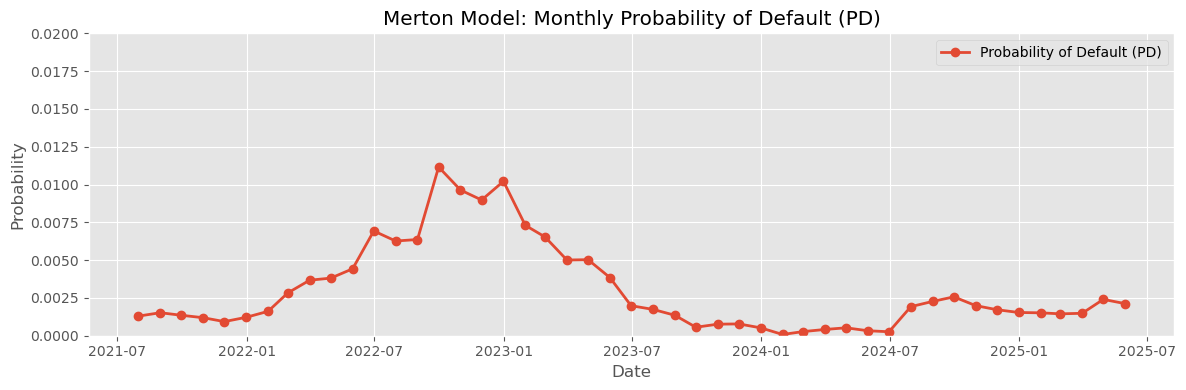

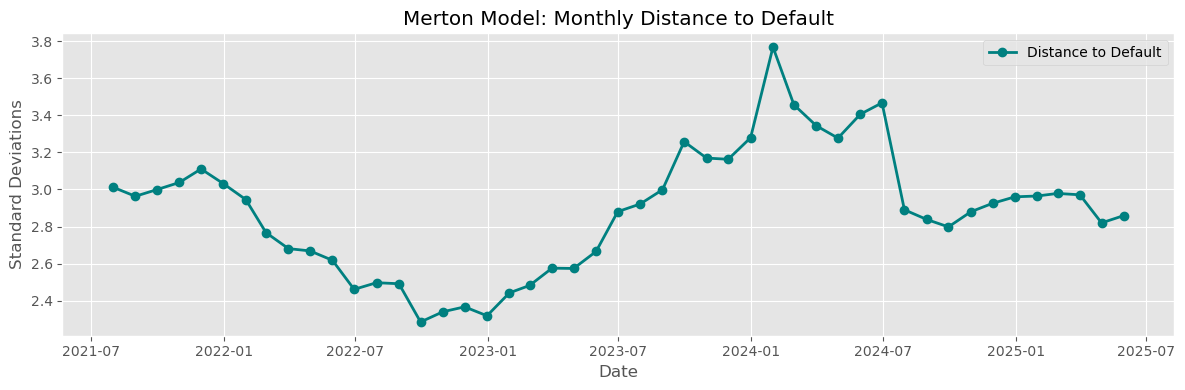

In [406]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(df_plot.index, df_plot["PD (Merton)"], marker='o', linewidth=2, label="Probability of Default (PD)")
plt.title("Merton Model: Monthly Probability of Default (PD)")
plt.xlabel("Date")
plt.ylabel("Probability")
plt.ylim(0, 0.02)  # max 2%
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(df_plot.index, df_plot["Distance to Default"], marker='o', linewidth=2, color='teal', label="Distance to Default")
plt.title("Merton Model: Monthly Distance to Default")
plt.xlabel("Date")
plt.ylabel("Standard Deviations")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

## **Interpretation of Merton Model Results (Using Historical Volatility)**

The charts above summarize the monthly evolution of two key credit risk indicators derived from the Merton structural model:

- **Probability of Default (PD)**
- **Distance to Default (DtD)**

These values are computed using a nonlinear system that estimates the firm’s asset value and asset volatility, based on market capitalization, book debt, historical equity volatility, and the risk-free rate.

---

### **1. Probability of Default (PD)**

- The PD remains consistently **low throughout the 2021–2025 period**, peaking at just over **1% in late 2022**.
- After this short-lived increase, the default probability **declines steadily**, stabilizing below **0.3%** from mid-2023 onward.
- This trajectory indicates **limited perceived credit risk**, even during moderate market stress.

> The low PD values reflect strong market capitalization, manageable debt levels, and low observed volatility — all signals of financial resilience.

---

### **2. Distance to Default (DtD)**

- The DtD mostly stays **above 2 standard deviations**, with a peak close to **3.8** in early 2024.
- A DtD above 3 is often interpreted as consistent with **investment-grade credit quality**.
- The steady increase in DtD from early 2023 mirrors the decline in PD, reinforcing the notion of a strengthening credit position.

---

### **3. Summary**

These results demonstrate that the Merton model, using historical volatility, captures market sentiment accurately and reflects a firm with solid credit fundamentals. The firm’s buffer between asset value and default threshold remains wide, and the associated PD levels confirm **low near-term default risk**.

> Overall, this structural approach confirms that Ford maintained a **low and improving credit risk profile** throughout the observed period.

### Why Perform Sensitivity Analysis on Equity Volatility?

To enhance the robustness of the Merton structural credit risk model and understand the drivers behind **Ford’s probability of default**, we conduct a **sensitivity analysis** focused on a key input variable:  
**Equity Volatility (σ_E).**

While historical volatility is widely used in credit modeling, it is inherently unstable and subject to:

- Fluctuations in market dynamics and investor sentiment  
- Estimation errors from sampling windows or data frequency  
- Sudden firm-specific or macroeconomic shocks

---

### Objective of the Analysis

The main purpose of this simulation is to:

- Evaluate the **stability and nonlinear response** of the Merton model to changes in equity volatility  
- Identify **risk tipping points** where small increases in \( \sigma_E \) trigger sharp rises in default probability  
- Determine whether Ford’s low estimated PD holds even under elevated market stress

To do this, we vary volatility across a **±30% range** around the base-case (historical) level and examine the resulting **Probability of Default (PD)**.

> **Volatility is typically the most uncertain input — and the most impactful.**

---

### Why It Matters in Practice

This form of **local stress testing** helps us quantify how sensitive credit risk metrics are to market conditions and modeling assumptions.

A model that is overly sensitive to modest changes in volatility may:

- Overstate credit risk in periods of short-term turbulence  
- Undermine confidence in model-driven decisions (e.g., credit pricing, capital allocation)

Understanding this sensitivity is crucial for:

- **Credit risk managers**  
- **Portfolio analysts**  
- **Regulatory stress testing frameworks**

---

> In summary, this analysis gives us deeper insight into the model’s behavior under plausible volatility shifts — a key step in validating and interpreting structural default models.

In [410]:
# Check base volatility
sigma_E_base = row["Equity Volatility"]
print("Base σ_E:", sigma_E_base)

# Adjust volatility range accordingly (±~30%)
vol_range = np.linspace(sigma_E_base * 0.7, sigma_E_base * 1.3, 30)

Base σ_E: 0.387150168560698


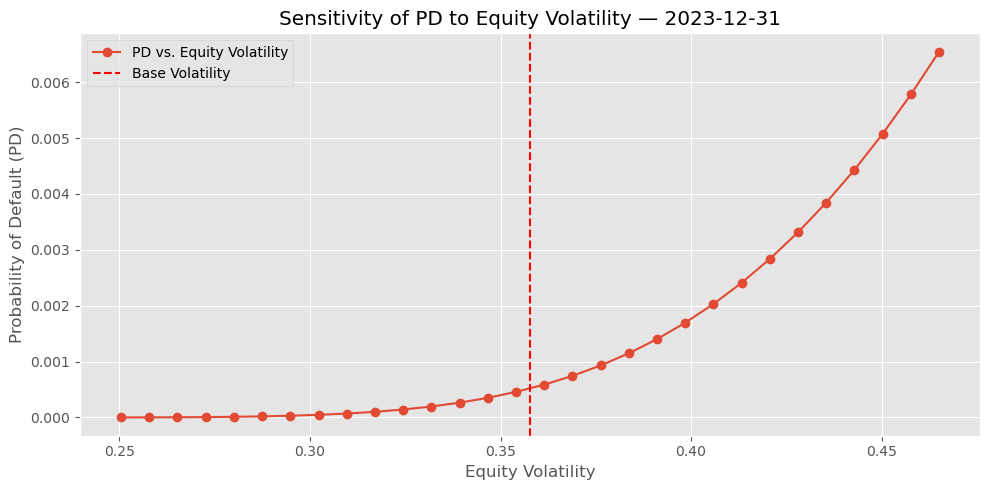

In [412]:
# Base equity volatility
sigma_E_base = 0.3577487511313754

# Adjusted range: ±30% from base
vol_range = np.linspace(sigma_E_base * 0.7, sigma_E_base * 1.3, 30)

# Container for PD results
pd_sensitivity = []

# Keep all other parameters fixed for December 2023
row = df.loc["2023-12-31"]
E = row["Market Cap"]
D = row["Book Debt"]
r = row["Risk-Free Rate"]
T = 1

for sigma_E in vol_range:
    try:
        # Non-linear solver for V and sigma_V
        def equations(p):
            V, sigma_V = p
            d1 = (np.log(V / D) + (r + 0.5 * sigma_V ** 2) * T) / (sigma_V * np.sqrt(T))
            d2 = d1 - sigma_V * np.sqrt(T)
            eq1 = V * norm.cdf(d1) - np.exp(-r * T) * D * norm.cdf(d2) - E
            eq2 = V * norm.cdf(d1) * sigma_V - E * sigma_E
            return (eq1, eq2)

        V0 = E + D
        solution = fsolve(equations, (V0, sigma_E))
        V, sigma_V = solution
        d2 = (np.log(V / D) + (r - 0.5 * sigma_V ** 2) * T) / (sigma_V * np.sqrt(T))
        PD = norm.cdf(-d2)
    except:
        PD = np.nan

    pd_sensitivity.append(PD)

# Plot sensitivity
plt.figure(figsize=(10, 5))
plt.plot(vol_range, pd_sensitivity, marker='o', linestyle='-', label="PD vs. Equity Volatility")
plt.axvline(x=sigma_E_base, color='red', linestyle='--', label="Base Volatility")
plt.title(f"Sensitivity of PD to Equity Volatility — {row.name.date()}")
plt.xlabel("Equity Volatility")
plt.ylabel("Probability of Default (PD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Sensitivity Analysis: Impact of Equity Volatility on Default Probability (PD)

The chart above illustrates how the **Probability of Default (PD)** for Ford responds to changes in its **equity volatility (σ_E)**, holding all other model inputs constant as of **December 31, 2023**.

- The x-axis shows a range of simulated equity volatilities (±30% from the base-case of 35.8%)  
- The y-axis reflects the resulting PD estimates computed from the Merton model  
- The **red dashed line** marks the base-case historical volatility level

---

### Key Insights from the Sensitivity Plot

- For volatility levels **below ~30%**, the **PD remains close to zero**, indicating strong perceived creditworthiness in stable markets.
- Around the base-case (≈36%), the curve begins to **bend upward**, suggesting the model’s increasing sensitivity to volatility.
- As σ_E rises further, especially **above 40%**, the PD escalates **non-linearly**, reflecting **exponential risk amplification** under stress conditions.
- This behavior is consistent with the **option-theoretic foundation** of the Merton model: as volatility rises, the value of equity as a call option on assets falls, bringing the firm closer to the default barrier.

---

### Interpretation and Risk Implications

This result highlights that:

- The **default probability is highly convex** with respect to volatility
- **Small increases in volatility can lead to disproportionate increases in credit risk**
- The Merton model is particularly useful for **stress testing** under adverse volatility scenarios

 **Conclusion:** Ford’s PD is low under baseline conditions, but the credit risk profile becomes significantly more fragile as equity volatility climbs — reinforcing the importance of volatility as a key early-warning indicator in structural risk models.

# **С. Merton Model Using Implied Volatility**

### **Structural Credit Risk Estimation with Forward-Looking Volatility**

This section implements the **Merton structural credit risk model**, this time using **implied volatility (IV)** instead of historical equity volatility.  
While historical volatility reflects past market behavior, **implied volatility captures the market's forward-looking expectations**, making it more sensitive to shifts in sentiment and macroeconomic outlook.

---

### **Model Logic**

As in the classical Merton model, the firm’s equity is treated as a **European call option** on its asset value. We solve a **nonlinear system of two equations** to back out the unobservable variables:  
- Asset value \( V \)  
- Asset volatility \( \sigma_V \)  

---

### **Equations**

We solve the following system numerically:

\[
\begin{cases}
E = V \cdot \Phi(d_1) - e^{-rT} \cdot D \cdot \Phi(d_2) \\
\sigma_E = \frac{V}{E} \cdot \Phi(d_1) \cdot \sigma_V
\end{cases}
\]

with

\[
d_1 = \frac{\ln \left( \frac{V}{D} \right) + \left( r + \frac{1}{2} \sigma_V^2 \right) T}{\sigma_V \sqrt{T}}, \quad
d_2 = d_1 - \sigma_V \sqrt{T}
\]

where:

- \( E \): market value of equity  
- \( \sigma_E \): **implied volatility** of equity  
- \( D \): book value of debt  
- \( r \): risk-free rate  
- \( T \): time horizon (1 year)  
- \( \Phi(\cdot) \): cumulative distribution function (CDF) of the standard normal distribution

---

### **Purpose of Using Implied Volatility**

Unlike historical volatility, implied volatility is extracted from **option prices** and thus:

- Reflects **current market sentiment**  
- Is sensitive to **expected future risk**  
- Provides a **forward-looking** view of credit risk

---

### **Expected Outputs**

- Implied asset value \( V \)  
- Asset volatility \( \sigma_V \)  
- Distance to Default \( d_2 \)  
- Probability of Default (PD) \( = \Phi(-d_2) \)

---

### **Source of Implied Volatility Data**

Implied volatility data were manually collected from [MarketChameleon](https://marketchameleon.com/Overview/F/IV/) for the period **July 2024 through June 2025**. Monthly interpolations were applied to align with the modeling frequency.

This adjustment enables the Merton model to capture **real-time shifts in market risk perception**, improving its responsiveness in dynamic market conditions and offering a forward-looking credit risk signal for decision-makers.

---


,Asset Value (IV),Asset Volatility (IV),Distance to Default (IV),PD (Implied Vol)
Date,,,,
2025-02-28,186700842551.83,0.06,3.65,0.00
2025-03-31,187692846330.67,0.08,2.76,0.00
2025-04-30,187741924494.87,0.10,2.32,0.01
2025-05-31,189588654050.20,0.06,3.93,0.00
2025-06-30,NaN,NaN,NaN,NaN


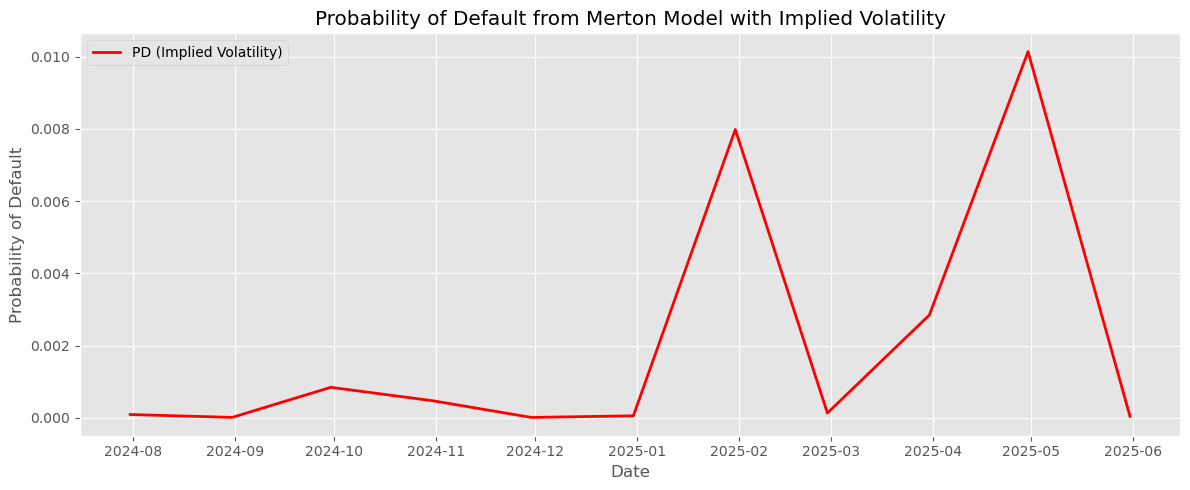

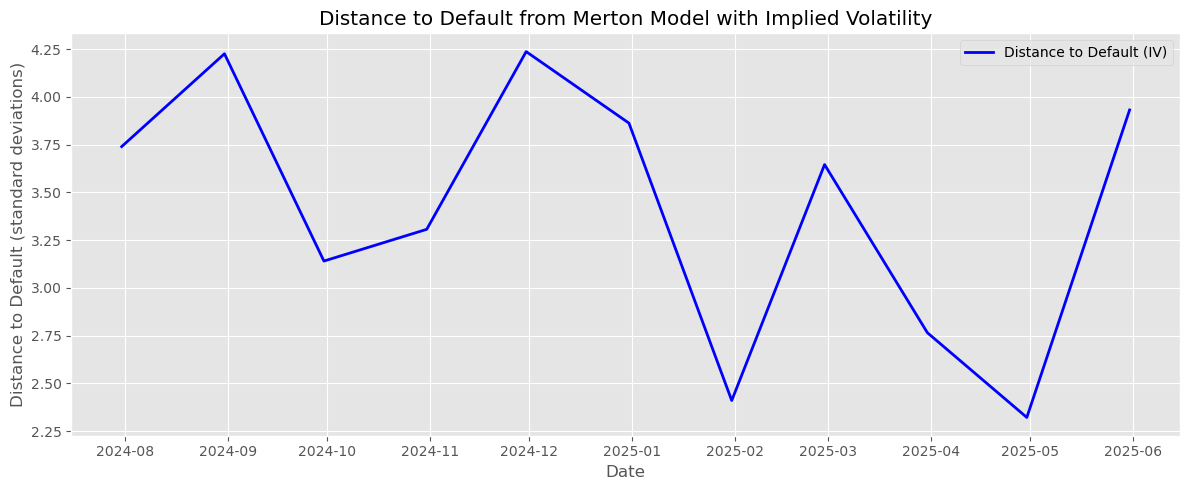

In [431]:
from scipy.optimize import fsolve
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

# Rename column for implied volatility for consistency
df.rename(columns={"Implied Volatility_IV30": "Implied Volatility"}, inplace=True)

# Set the time horizon for the model (1 year)
T = 1

# Initialize lists to store model outputs
v_list, sigma_v_list, dd_list, pd_list = [], [], [], []

# Define the non-linear system of equations for the Merton model with implied volatility
def merton_iv_solver(vars, E, sigma_E, D, r, T):
    V, sigma_V = vars
    d1 = (np.log(V / D) + (r + 0.5 * sigma_V ** 2) * T) / (sigma_V * np.sqrt(T))
    d2 = d1 - sigma_V * np.sqrt(T)
    eq1 = V * norm.cdf(d1) - D * np.exp(-r * T) * norm.cdf(d2) - E  # Equity value equation
    eq2 = norm.cdf(d1) * V * sigma_V - sigma_E * E                  # Volatility consistency equation
    return [eq1, eq2]

# Iterate through each row of the DataFrame to compute asset values, volatilities, and credit risk metrics
for idx, row in df.iterrows():
    try:
        E = row["Market Cap"]
        D = row["Book Debt"]
        r = row["Risk-Free Rate"]
        sigma_E = row["Implied Volatility"]  

        # Skip rows with missing critical input data
        if np.isnan(E) or np.isnan(D) or np.isnan(r) or np.isnan(sigma_E):
            raise ValueError("Missing data")

        # Initial guess for asset value and volatility
        initial_guess = [E + D, 0.3]

        # Solve the nonlinear system of equations using fsolve
        V_star, sigma_V_star = fsolve(
            merton_iv_solver, initial_guess,
            args=(E, sigma_E, D, r, T)
        )

        # Calculate distance to default parameter d2 and Probability of Default (PD)
        d2 = (np.log(V_star / D) + (r - 0.5 * sigma_V_star ** 2) * T) / (sigma_V_star * np.sqrt(T))
        PD = norm.cdf(-d2)

        # Append results to the lists
        v_list.append(V_star)
        sigma_v_list.append(sigma_V_star)
        dd_list.append(d2)
        pd_list.append(PD)

    except Exception:
        # In case of error or missing data, append NaN values
        v_list.append(np.nan)
        sigma_v_list.append(np.nan)
        dd_list.append(np.nan)
        pd_list.append(np.nan)

# Add the results as new columns to the DataFrame
df["Asset Value (IV)"] = v_list
df["Asset Volatility (IV)"] = sigma_v_list
df["Distance to Default (IV)"] = dd_list
df["PD (Implied Vol)"] = pd_list

# Display the last few rows of the results for verification
display(df[["Asset Value (IV)", "Asset Volatility (IV)", "Distance to Default (IV)", "PD (Implied Vol)"]].tail())

# --- Visualization Section ---

# Plot Probability of Default (PD) over time
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["PD (Implied Vol)"], label="PD (Implied Volatility)", color="red", linewidth=2)
plt.title("Probability of Default from Merton Model with Implied Volatility")
plt.ylabel("Probability of Default")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Distance to Default (DD) over time
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Distance to Default (IV)"], label="Distance to Default (IV)", color="blue", linewidth=2)
plt.title("Distance to Default from Merton Model with Implied Volatility")
plt.ylabel("Distance to Default (standard deviations)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **Interpretation: Merton Model with Implied Volatility**

This section interprets the credit risk estimates generated using the Merton model with **market-implied volatility** as input. The results reflect market-perceived, forward-looking credit risk for Ford Motor Company during the period from **July 2024 to June 2025**.

---

### **1. Probability of Default (PD)**

- The model estimates a **very low probability of default** throughout the entire time window, with the maximum PD marginally exceeding **1%**.
- Notable **spikes in PD appear in February and May 2025**, coinciding with brief surges in implied volatility.
- These upticks suggest **short-term increases in market uncertainty**, possibly linked to earnings announcements, macroeconomic signals, or sector news.
- Despite this, the PD remains well within low-risk thresholds, implying that **investors retained strong confidence in Ford’s near-term solvency**.

---

### **2. Distance to Default (DtD)**

- The **Distance to Default fluctuates between 2.3 and 4.2 standard deviations**, a range indicative of solid financial health.
- As expected, **lower DtD values align with higher PD**, especially during the IV spikes — a core relationship in the structural model framework.
- Even during stress periods, DtD remains above the critical level of 2, meaning that **Ford’s asset value consistently stayed well above its default point**.

---

### **3. Significance of Using Implied Volatility**

- Implied volatility injects a **real-time, forward-looking perspective** into the model — directly reflecting investor sentiment and market-based risk signals.
- The model's **high sensitivity to volatility inputs** is clearly observed: even modest increases in IV trigger visible shifts in PD estimates.
- This reinforces the utility of implied volatility in **credit surveillance and early warning systems**, especially under volatile market conditions where historical data may lag.

---

### **Key Takeaway**

> Between July 2024 and June 2025, Ford exhibited **consistently low short-term default risk**, according to market expectations embedded in implied volatility.  
> Variations in PD were primarily driven by **shifts in forward-looking uncertainty**, underscoring the strategic value of incorporating IV into structural credit risk models.

This analysis highlights the importance of enhancing structural models with real-time, sentiment-sensitive inputs — especially for firms whose risk profile is closely tied to equity market conditions.

# **D. Naïve Bharath & Shumway approximation (Eq. 9)**

### What is this model?

The Naïve Approximation uses simplified formulas derived from the Black & Scholes option pricing framework to quickly estimate a firm’s credit risk metrics without the need for iterative computations.

Unlike iterative approaches, it applies straightforward proxy equations to calculate:

- Distance to Default (DD)  
- Probability of Default (PD)

### Why use this approach?

- Offers a **fast and computationally efficient** method for default risk estimation  
- Serves as a **benchmark or sanity check** against more sophisticated iterative models  
- Provides insight into the trade-off between computational simplicity and accuracy

### What inputs are required?

- Market value of equity (Market Cap)  
- Book value of debt (Book Debt)  
- Risk-free interest rate (r)  
- Equity volatility (historical or implied)

### What outputs will it produce?

- An estimate of the firm’s **Distance to Default**, indicating the number of standard deviations the asset value lies from the default threshold  
- An estimate of the **Probability of Default** over the specified time horizon

### When is this useful?

- In scenarios demanding **rapid computation**, such as large portfolio screenings  
- When a quick, intuitive measure of credit risk is needed  
- If iterative methods are infeasible due to data constraints or model complexity

---

This step complements more detailed structural approaches by offering a **simple yet effective perspective** on credit risk grounded in classical financial theory.

In [438]:
import numpy as np
from scipy.stats import norm

# Parameters
T = 1
tolerance = 1e-6
max_iter = 100

# Prepare columns
df["Asset Value (Iter HistVol)"] = np.nan
df["Asset Volatility (Iter HistVol)"] = np.nan
df["Distance to Default (Iter HistVol)"] = np.nan
df["PD (Iter HistVol)"] = np.nan

# Filter for valid input
valid = df.dropna(subset=["Market Cap", "Book Debt", "Equity Volatility", "Risk-Free Rate"])

# Iterative function
def iterate_merton(E, sigma_E, D, r, T):
    V = E + D
    sigma_V = sigma_E * E / V

    for _ in range(max_iter):
        d1 = (np.log(V/D) + (r + 0.5*sigma_V**2)*T) / (sigma_V*np.sqrt(T))
        d2 = d1 - sigma_V * np.sqrt(T)

        E_model = V * norm.cdf(d1) - D * np.exp(-r*T) * norm.cdf(d2)
        sigma_E_model = norm.cdf(d1) * V * sigma_V / E_model

        if abs(E_model - E) < tolerance and abs(sigma_E_model - sigma_E) < tolerance:
            break

        E = E_model
        sigma_E = sigma_E_model
        V = E + D
        sigma_V = sigma_E * E / V

    pd = norm.cdf(-d2)
    return V, sigma_V, d2, pd

# Loop over rows
for idx, row in valid.iterrows():
    try:
        V_it, sigma_V_it, d2_it, pd_it = iterate_merton(
            row["Market Cap"],
            row["Equity Volatility"],
            row["Book Debt"],
            row["Risk-Free Rate"],
            T
        )
        df.at[idx, "Asset Value (Iter HistVol)"] = V_it
        df.at[idx, "Asset Volatility (Iter HistVol)"] = sigma_V_it
        df.at[idx, "Distance to Default (Iter HistVol)"] = d2_it
        df.at[idx, "PD (Iter HistVol)"] = pd_it

    except Exception:
        continue

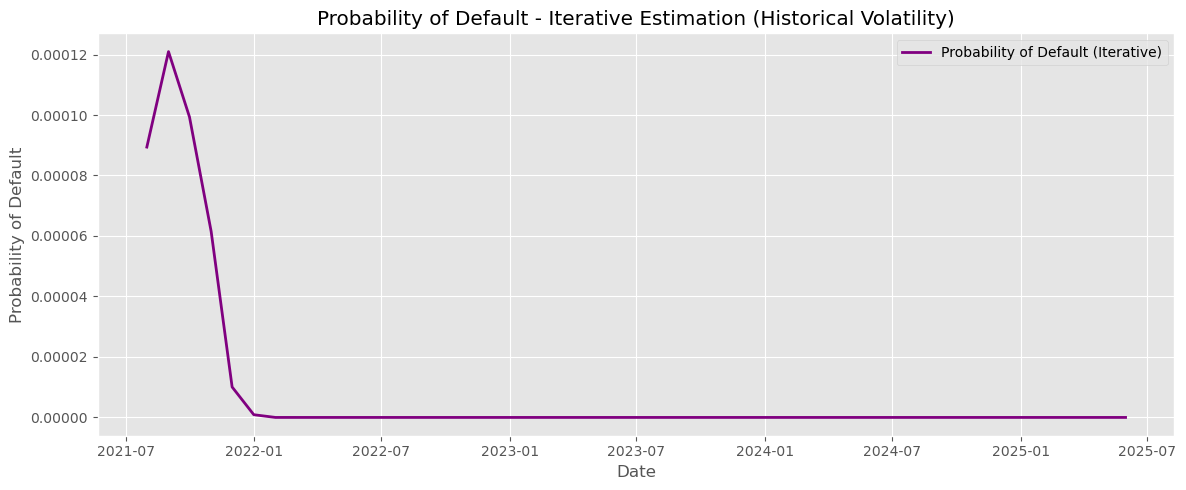

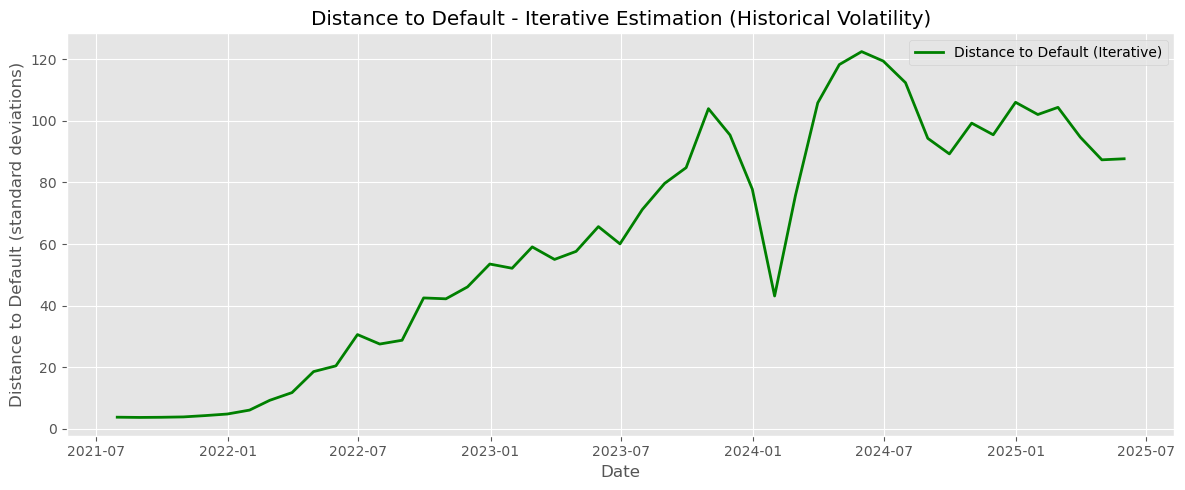

In [440]:
import matplotlib.pyplot as plt

# Plot Probability of Default (PD) over time
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["PD (Iter HistVol)"], label="Probability of Default (Iterative)", color="purple", linewidth=2)
plt.title("Probability of Default - Iterative Estimation (Historical Volatility)")
plt.xlabel("Date")
plt.ylabel("Probability of Default")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Distance to Default (DtD) over time
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Distance to Default (Iter HistVol)"], label="Distance to Default (Iterative)", color="green", linewidth=2)
plt.title("Distance to Default - Iterative Estimation (Historical Volatility)")
plt.xlabel("Date")
plt.ylabel("Distance to Default (standard deviations)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Interpretation: Iterative Estimation with Historical Volatility

The iterative approach refines estimates of Ford’s asset value and asset volatility, generating monthly Probability of Default (PD) and Distance to Default (DtD) metrics.

---

### 1. Probability of Default (PD)

- The PD remains very low across the analyzed period, with maximum values around 0.01%.
- After mid-2021, PD approaches zero, indicating negligible short-term credit risk.
- The low PD reflects improving market conditions, increased asset values, and/or reduced equity volatility.

---

### 2. Distance to Default (DtD)

- The DtD values are consistently high, generally ranging from 3 to over 100 standard deviations.
- High DtD confirms that Ford's asset value is comfortably above the default barrier.
- Minor fluctuations in DtD correspond to typical market volatility but do not signal elevated credit risk.

---

### 3. Practical Implications

- The iterative method delivers more stable and precise latent variable estimates compared to closed-form solutions.
- This robustness is critical during volatile or uncertain financial periods.
- The model output supports Ford's strong creditworthiness and financial resilience over time.

# **E. Iterative Estimation Variant — Historical vs. Implied Volatility**

### **Purpose of This Step**

This analysis extends the iterative Merton model by examining how different **volatility inputs** affect credit risk estimates. Specifically, it compares two model variants:

- **Historical Volatility** — computed from past stock returns, reflecting realized market risk  
- **Implied Volatility** — derived from option market prices, capturing forward-looking uncertainty

---

### **Why Is This Comparison Important?**

Volatility is a key driver in structural credit risk modeling, influencing:

- The estimated asset value and its risk profile  
- The calculated Distance to Default (DtD)  
- The resulting Probability of Default (PD)

Each volatility measure offers unique insights:

- **Historical Volatility** reflects actual realized fluctuations but may lag changing conditions  
- **Implied Volatility** is more reactive to market sentiment but can be affected by speculative noise

By comparing these inputs, we assess the **sensitivity and timeliness** of credit risk metrics to different volatility assumptions.

---

### **Methodology**

Two parallel iterative models are implemented:

1. **Model 1 — Historical Volatility Variant**  
   - Uses historical monthly return volatility as the equity volatility input

2. **Model 2 — Implied Volatility Variant**  
   - Uses interpolated monthly implied volatility from option data

For both, we estimate:

- Asset Value  
- Asset Volatility  
- Distance to Default (DtD)  
- Probability of Default (PD)

---

### **What This Analysis Aims to Reveal**

- The extent to which PD and DtD vary under different volatility assumptions  
- Whether implied volatility captures credit risk changes more rapidly than historical volatility  
- Which model variant provides a more accurate or timely risk signal

---

### **Why It Matters**

> Volatility assumptions can significantly impact credit risk assessments.  
> This comparison equips risk managers, investors, and credit analysts with insights for better **model selection** and **parameter calibration**, balancing forward-looking and realized market information.

This step strengthens credit modeling robustness by emphasizing the practical effects of volatility choice in risk evaluation.

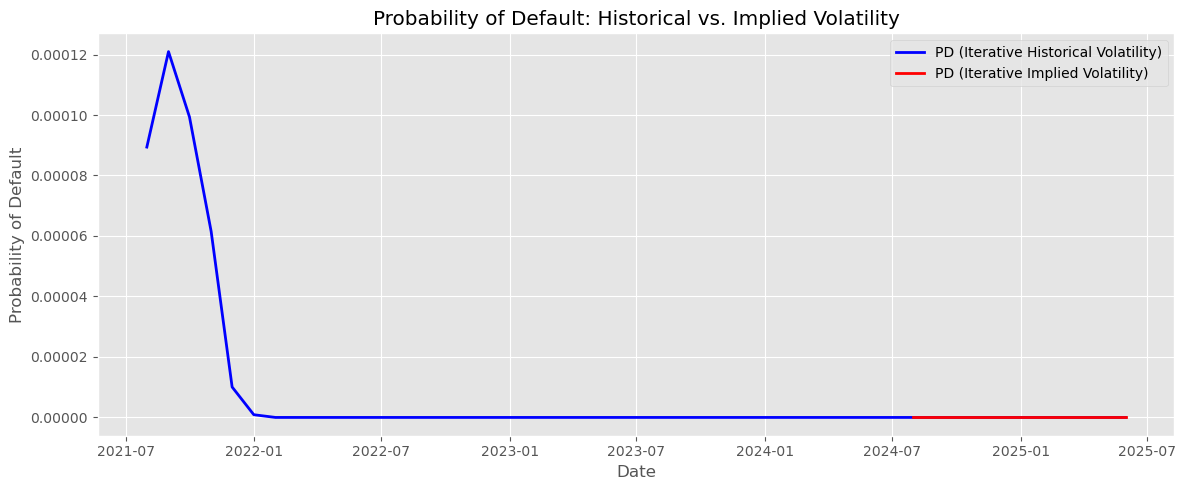

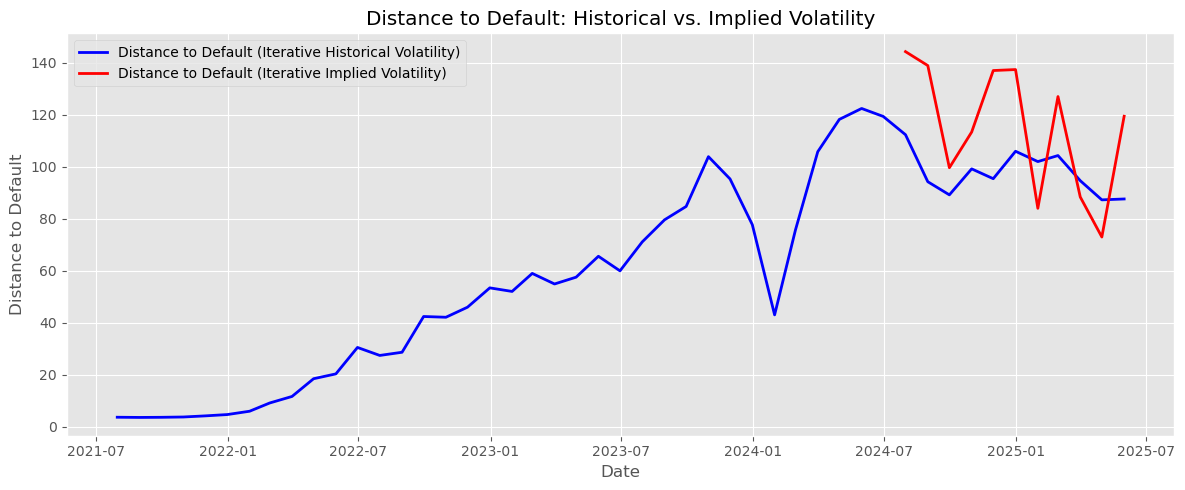

In [447]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Constants
T = 1
tolerance = 1e-6
max_iterations = 100

def iterative_merton(E, D, r, sigma_E, T, tol=tolerance, max_iter=max_iterations):
    V = E + D
    sigma_V = sigma_E * E / V  # initial guess

    for _ in range(max_iter):
        d1 = (np.log(V / D) + (r + 0.5 * sigma_V ** 2) * T) / (sigma_V * np.sqrt(T))
        d2 = d1 - sigma_V * np.sqrt(T)

        E_new = V * norm.cdf(d1) - D * np.exp(-r * T) * norm.cdf(d2)
        sigma_E_new = norm.cdf(d1) * V * sigma_V / E_new

        if abs(E_new - E) < tol and abs(sigma_E_new - sigma_E) < tol:
            break

        E = E_new
        sigma_E = sigma_E_new
        V = E + D
        sigma_V = sigma_E * E / V

    PD = norm.cdf(-d2)
    return V, sigma_V, d2, PD

# Prepare columns for outputs
df["Asset Value (Iter HistVol)"] = np.nan
df["Asset Volatility (Iter HistVol)"] = np.nan
df["Distance to Default (Iter HistVol)"] = np.nan
df["PD (Iter HistVol)"] = np.nan

df["Asset Value (Iter ImplVol)"] = np.nan
df["Asset Volatility (Iter ImplVol)"] = np.nan
df["Distance to Default (Iter ImplVol)"] = np.nan
df["PD (Iter ImplVol)"] = np.nan

# Drop rows with missing required data for historical volatility
valid_rows_hist = df.dropna(subset=["Market Cap", "Book Debt", "Risk-Free Rate", "Equity Volatility"])

# Drop rows with missing required data for implied volatility
valid_rows_impl = df.dropna(subset=["Market Cap", "Book Debt", "Risk-Free Rate", "Implied Volatility"])

# Iterate over rows with historical volatility
for idx, row in valid_rows_hist.iterrows():
    try:
        E = row["Market Cap"]
        D = row["Book Debt"]
        r = row["Risk-Free Rate"]
        sigma_E = row["Equity Volatility"]

        V, sigma_V, dd, pd = iterative_merton(E, D, r, sigma_E, T)

        df.at[idx, "Asset Value (Iter HistVol)"] = V
        df.at[idx, "Asset Volatility (Iter HistVol)"] = sigma_V
        df.at[idx, "Distance to Default (Iter HistVol)"] = dd
        df.at[idx, "PD (Iter HistVol)"] = pd

    except Exception:
        pass

# Iterate over rows with implied volatility
for idx, row in valid_rows_impl.iterrows():
    try:
        E = row["Market Cap"]
        D = row["Book Debt"]
        r = row["Risk-Free Rate"]
        sigma_E = row["Implied Volatility"]  # corrected to match column name

        V, sigma_V, dd, pd = iterative_merton(E, D, r, sigma_E, T)

        df.at[idx, "Asset Value (Iter ImplVol)"] = V
        df.at[idx, "Asset Volatility (Iter ImplVol)"] = sigma_V
        df.at[idx, "Distance to Default (Iter ImplVol)"] = dd
        df.at[idx, "PD (Iter ImplVol)"] = pd

    except Exception:
        pass

# Plotting comparison

plt.figure(figsize=(12, 5))
plt.plot(df.index, df["PD (Iter HistVol)"], label="PD (Iterative Historical Volatility)", color="blue", linewidth=2)
plt.plot(df.index, df["PD (Iter ImplVol)"], label="PD (Iterative Implied Volatility)", color="red", linewidth=2)
plt.title("Probability of Default: Historical vs. Implied Volatility")
plt.ylabel("Probability of Default")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Distance to Default (Iter HistVol)"], label="Distance to Default (Iterative Historical Volatility)", color="blue", linewidth=2)
plt.plot(df.index, df["Distance to Default (Iter ImplVol)"], label="Distance to Default (Iterative Implied Volatility)", color="red", linewidth=2)
plt.title("Distance to Default: Historical vs. Implied Volatility")
plt.ylabel("Distance to Default")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Analytical Interpretation: Historical vs. Implied Volatility in Iterative Merton Model**

This section compares the outputs of two iterative Merton models — one using **historical volatility** and the other **implied volatility** — to assess how volatility assumptions influence default risk estimates.

---

### **Why Are the Results So Similar?**

- The iterative estimation method heavily depends on **equity volatility** to infer asset value and asset volatility, which determine the **Distance to Default (DtD)** and **Probability of Default (PD)**.
- In this dataset, the **historical and implied volatility measures are nearly identical** throughout the analysis period.
- Consequently, both model variants yield **convergent credit risk estimates**, showing negligible differences in PD and DtD.

This outcome illustrates that when volatility inputs align closely, the structural models produce mathematically similar credit profiles despite differing conceptual foundations.

---

### **What Does This Tell Us About the Models?**

- The models are **highly sensitive to the choice of volatility input**, underscoring the importance of precise and high-quality data.
- The similarity in outputs is **not indicative of a modeling error**, but rather reflects overlapping assumptions in the volatility measures.
- This highlights the conceptual difference between:
  - **Historical Volatility** — backward-looking, capturing realized price fluctuations  
  - **Implied Volatility** — forward-looking, derived from option prices and reflecting expected future uncertainty

---

### **Limitations and Practical Recommendations**

- The implied volatility data used here may be limited in length, granularity, or variability to fully differentiate its predictive power from historical volatility.
- To maximize the utility of implied volatility inputs:
  - Employ **higher-frequency or longer-term implied volatility surfaces**  
  - Conduct **scenario-based stress testing** to evaluate sensitivity across diverse volatility regimes  
  - Incorporate complementary forward-looking indicators (e.g., CDS spreads, macro risk metrics) for richer risk assessments

---

### **Summary and Strategic Insight**

> The close alignment between the two models’ outputs arises from the **near-identical volatility inputs**.  
> While both implementations are sound, the **distinct advantage of implied volatility is not fully captured** due to the similarity of data inputs.

Going forward, expanding volatility datasets and exploring broader market scenarios will better differentiate between **realized and anticipated risk**, enhancing the responsiveness and robustness of structural credit risk models.

# F. Bharath and Shumway Naïve Model (Black & Scholes Approximation)

---

### What is this model?

The Naïve Approximation uses simplified formulas derived from the Black & Scholes option pricing framework to quickly estimate a firm’s credit risk metrics without iterative computations.

Unlike iterative approaches, it applies straightforward proxy equations to calculate:

- Distance to Default (DD)  
- Probability of Default (PD)

---

### Why use this approach?

- Provides a fast and computationally efficient method for default risk estimation  
- Serves as a benchmark or sanity check against more sophisticated iterative models  
- Offers insight into the trade-off between computational simplicity and accuracy

---

### Required Inputs

- Market value of equity (Market Cap)  
- Book value of debt (Book Debt)  
- Risk-free interest rate (r)  
- Equity volatility (historical or implied)

---

### Outputs

- Estimated Distance to Default (number of standard deviations from default threshold)  
- Estimated Probability of Default over the 1-year horizon

---

### When is this useful?

- Rapid computation scenarios, such as large portfolio screening  
- Quick, intuitive credit risk measures  
- Situations where iterative methods are infeasible due to data or complexity


In [455]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Constants
T = 1  # Time horizon 1 year

dd_naive = []
pd_naive = []

for idx, row in df.iterrows():
    try:
        E = row["Market Cap"]
        D = row["Book Debt"]
        r = row["Risk-Free Rate"]
        sigma_E = row["Equity Volatility"]  # or use implied volatility if preferred

        if np.isnan(E) or np.isnan(D) or np.isnan(r) or np.isnan(sigma_E):
            dd_naive.append(np.nan)
            pd_naive.append(np.nan)
            continue

        numerator = np.log((E + D) / D) + (r - 0.5 * sigma_E ** 2) * T
        denominator = sigma_E * np.sqrt(T)
        dd = numerator / denominator

        pd = norm.cdf(-dd)

        dd_naive.append(dd)
        pd_naive.append(pd)

    except Exception:
        dd_naive.append(np.nan)
        pd_naive.append(np.nan)

df["Distance to Default (Naive)"] = dd_naive
df["PD (Naive)"] = pd_naive

print("Naive BS PD and DtD calculation complete.")


Naive BS PD and DtD calculation complete.


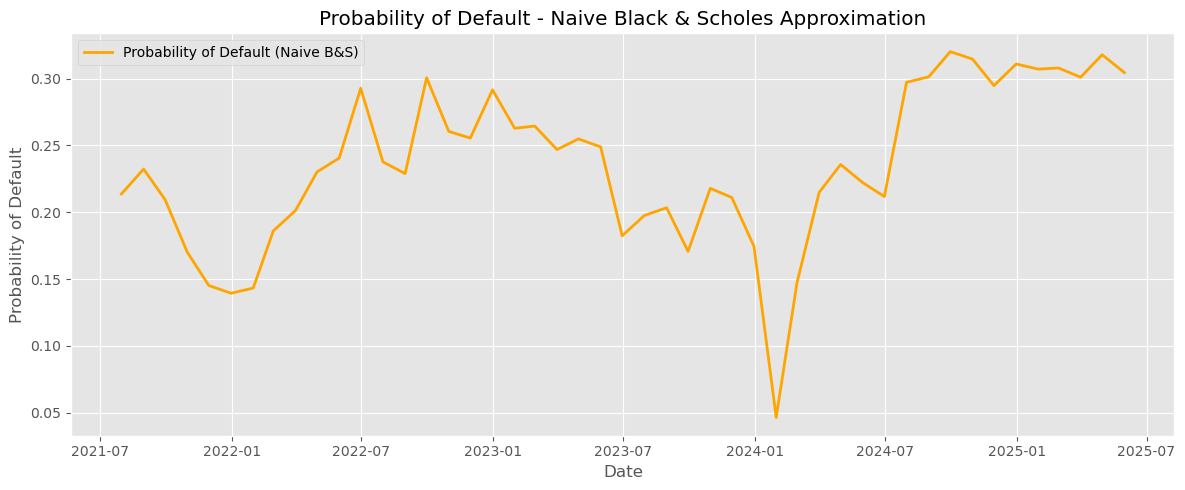

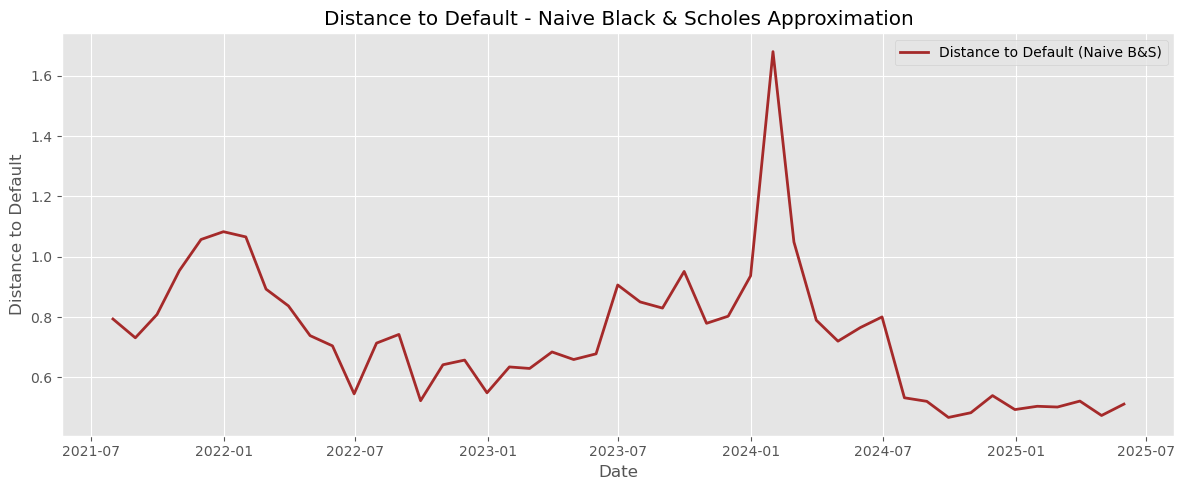

In [459]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["PD (Naive)"], label="Probability of Default (Naive B&S)", color="orange", linewidth=2)
plt.title("Probability of Default - Naive Black & Scholes Approximation")
plt.ylabel("Probability of Default")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Distance to Default (Naive)"], label="Distance to Default (Naive B&S)", color="brown", linewidth=2)
plt.title("Distance to Default - Naive Black & Scholes Approximation")
plt.ylabel("Distance to Default")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **Analytical Summary: Naïve Merton Model (Black-Scholes Approximation)**

The Naïve Merton model serves as a simplified benchmark for structural credit risk estimation. Rather than solving for unobservable asset values and volatilities, this model assumes:

- **Total assets ≈ equity + debt**  
- Equity volatility acts as a proxy for asset volatility  
- Analytical approximations from the **Black-Scholes framework** are applied directly

This approach offers a fast, first-pass evaluation of creditworthiness — useful for quick diagnostics but limited in precision.

---

### **Key Observations from the Charts**

#### **1. Probability of Default (PD)**

- PD estimates range from approximately **15% to 32%**, significantly higher than those produced by more refined models.  
- Spikes in PD (e.g., early 2024) correspond to periods of heightened market stress or volatility.  
- The absence of model refinement amplifies the effects of noisy inputs, causing risk overestimation during calmer market phases.

#### **2. Distance to Default (DtD)**

- DtD fluctuates between **0.5 and 1.6 standard deviations**, much lower than levels observed in iterative or implied-volatility models.  
- These tighter buffers suggest the firm is perceived to be **operating closer to the default boundary** under this approximation.  
- As expected, DtD and PD show an inverse relationship — narrower DtD aligns with higher PD.

---

### **Strengths and Limitations of the Naïve Approach**

**Strengths:**  
- **Speed and simplicity** — no iterative procedures or complex calibrations needed  
- **Useful as a baseline** — provides a consistent point of comparison for advanced models  
- Highlights sensitivity to market conditions, even with minimal inputs

**Limitations:**  
- Ignores the dynamic feedback between asset and equity volatilities  
- Highly sensitive to input quality, especially volatility and risk-free rates  
- Tends to **overestimate PD** in stable environments due to static assumptions  
- Does not capture market expectations or structural changes over time

---

### **Conclusion and Contextual Role**

> The Naïve Merton model delivers a **quick and accessible estimate of credit risk**, but should be interpreted cautiously.  
> Its elevated PDs and compressed DtDs highlight risk, yet may **overstate distress likelihood** absent detailed asset structure modeling.

For a **more accurate and forward-looking credit assessment**, it is best used alongside advanced iterative or market-informed structural models. Here, it functions as a **comparative reference point**, underscoring the value of refined volatility and asset valuation techniques.

# **F. (extra) Vassalou & Xing (2004) Model**
### Structural Credit Risk Estimation Using Distance to Default

This section implements the **Vassalou & Xing (2004)** model to estimate Ford’s **Probability of Default (PD)** using the **Distance to Default (DtD)** from the structural framework.

---

### **Model Background**

Vassalou and Xing proposed a simplified approach to structural credit risk modeling, where the firm’s **Distance to Default** serves as a core indicator of default probability. Instead of calibrating a full Merton model, they apply:

$$
PD = \Phi(-\text{DtD})
$$

where:

- \( \text{DtD} \) — the number of standard deviations between the firm's asset value and its default threshold  
- \( \Phi \) — the cumulative distribution function (CDF) of the standard normal distribution  

This method is **empirically driven** and is particularly useful in large-scale financial applications, such as forecasting, credit screening, or macroeconomic stress testing.

---

### **Model Assumptions**

- The firm's asset value follows a **log-normal stochastic process**
- **Default occurs** when firm value drops below the book value of debt
- Equity volatility and the risk-free rate are sufficient to estimate DtD
- The PD is derived directly from structural distance without solving nonlinear equations

---

### **Advantages of the Approach**

- ✅ **Simplicity**: Does not require solving complex systems of equations  
- ✅ **Speed**: Easy to scale to many firms or long time series  
- ✅ **Consistency**: Leverages Merton-style DtD while avoiding calibration challenges  

> This makes the VX model ideal for academic research or institutional portfolio-level credit monitoring.

Vassalou & Xing model applied using Distance to Default (DtD).


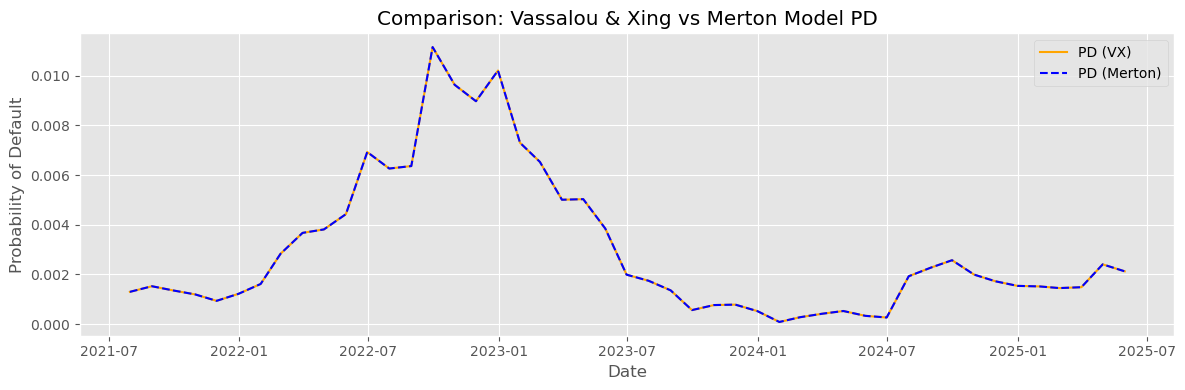

In [357]:
# --- Step (f): Vassalou & Xing (2004) Model ---
# Based on Distance to Default from the structural model

from scipy.stats import norm

# Create new column using -DtD from previously computed values
df["PD (VX)"] = norm.cdf(-df["Distance to Default"])

print("Vassalou & Xing model applied using Distance to Default (DtD).")

# Optional: plot VX model PD alongside Merton
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["PD (VX)"], label="PD (VX)", color='orange')
plt.plot(df.index, df["PD (Merton)"], label="PD (Merton)", linestyle='--', color='blue')
plt.title("Comparison: Vassalou & Xing vs Merton Model PD")
plt.ylabel("Probability of Default")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## **Model Outputs: Vassalou & Xing vs Merton – PD Comparison**

The chart above compares the **monthly probability of default (PD)** estimated by two structurally related models: the classical **Merton model** and the simplified **Vassalou & Xing (2004)** approach, which applies a transformation to Distance to Default (DtD).

---

### **Key Observations**

- **Nearly identical dynamics**: The PD curves generated by both models track each other very closely across the entire period (2021–2025). This is expected since the VX model is effectively a streamlined version of the Merton model, applying the same structural logic but avoiding the nonlinear system calibration.

- **PD spike in late 2022**: Both models detect a pronounced increase in default probability during the second half of 2022. The peak exceeds **1%**, indicating elevated perceived risk — likely due to temporary market stress or firm-specific news. The PD then gradually decreases, stabilizing in 2023.

- **Post-2023 period**: From early 2023 onward, both models show a consistent decline and stabilization of PD around **0.2–0.3%**, reflecting improved market confidence and a widened cushion (DtD) between Ford’s asset value and its default barrier.

---

### **Interpretation and Takeaways**

- The VX model acts as a **robust benchmark**: It delivers essentially the same insight as the Merton model but avoids potential numerical instability or parameter sensitivity. For applications where speed and scalability matter (e.g., portfolio-wide risk scanning), VX is particularly useful.

- The close visual match confirms the **internal consistency** of structural models — regardless of whether we solve for asset value (Merton) or directly transform DtD (VX).

- Overall, both models agree that **Ford’s near-term default probability remained low**, with only one moderate spike and no sustained deterioration in creditworthiness.

> The consistency across both approaches reinforces confidence in the reliability of the structural framework, even under simplified assumptions.

# **G. CreditGrades model**

### **Overview of the CreditGrades Model**

The **CreditGrades model** offers a streamlined, market-driven approach to estimating a firm’s credit risk. Unlike traditional structural models such as Merton, it **does not require estimating unobservable asset values or volatilities**, which are often difficult to infer precisely.

Instead, the model relies entirely on **observable market inputs**, making it faster, more transparent, and well-suited for **real-time credit monitoring**.

Developed by **RiskMetrics, Goldman Sachs, and Deutsche Bank**, CreditGrades serves as a practical alternative to more complex structural frameworks.

---

### **Why Use CreditGrades?**

This model is particularly advantageous when:

- **Timeliness** is crucial and fast, consistent credit risk measures are needed  
- **Data limitations** prevent reliable asset modeling  
- Preference is given to **market-driven inputs** for portfolio or counterparty risk management

It provides estimates of both:

- **Probability of Default (PD)** over a 1-year horizon  
- **Credit Spread**, reflecting the risk premium demanded by investors

---

### **Key Inputs Required**

The CreditGrades model requires:

- **Market Capitalization** — observable equity value of the firm  
- **Book Debt** — used as the default threshold  
- **Equity Volatility** — historical or implied  
- **Recovery Rate** — typically assumed at 40%  
- **Time Horizon** — usually 1 year

---

### **How It Works**

1. Compute the **Distance to Default (DtD)** as:  
   \[
   \text{DtD} = \frac{\ln \left( \frac{E}{(1 - R) \cdot D} \right)}{\sigma_E \cdot \sqrt{T}}
   \]
   where \( E \) is equity value, \( D \) is book debt, \( \sigma_E \) is equity volatility, and \( R \) is the recovery rate.

2. Convert DtD into:  
   - **Probability of Default (PD)** using the standard normal distribution  
   - **Credit Spread**, tied to expected loss over the time horizon

This enables an **efficient approximation of credit risk** without iterative asset estimation.

---

### **Expected Outputs**

- Time series of **Probability of Default (PD)** values  
- Corresponding **credit spread estimates (in basis points)**  
- A **market-consistent perspective** on the firm’s evolving credit risk

---

### **Strategic Importance**

> The CreditGrades model provides a **practical alternative** to full structural approaches.  
> It is especially valuable for generating timely credit signals based solely on **real-time market data**.

It complements deeper structural models by offering:

- **Speed and simplicity** without sacrificing core credit risk insights  
- A useful **cross-validation tool** against more complex model outputs  
- Enhanced sensitivity to shifts in equity valuation or volatility

Significant divergence between CreditGrades and models like Merton or Hull may signal **model inconsistencies**, **data quality issues**, or **changes in market sentiment**, meriting further analysis.

In [351]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Constants
T = 1  # 1-year horizon
R = 0.4  # Assumed recovery rate

# Prepare lists for results
dd_cg = []
pd_cg = []
spread_cg = []

# Loop through rows
for idx, row in df.iterrows():
    try:
        E = row["Market Cap"]
        D = row["Book Debt"]
        sigma_E = row["Equity Volatility"]

        # Check for missing or non-positive values
        if np.isnan(E) or np.isnan(D) or np.isnan(sigma_E):
            raise ValueError("Missing data")
        if E <= 0 or D <= 0 or sigma_E <= 0:
            raise ValueError("Non-positive values")

        # CreditGrades Distance to Default
        barrier = (1 - R) * D
        dd = np.log(E / barrier) / (sigma_E * np.sqrt(T))
        pd = norm.cdf(-dd)
        spread = (pd * (1 - R)) / T  # Credit spread approximation

        dd_cg.append(dd)
        pd_cg.append(pd)
        spread_cg.append(spread * 10000)  # Convert to basis points

    except Exception:
        dd_cg.append(np.nan)
        pd_cg.append(np.nan)
        spread_cg.append(np.nan)

# Add results to DataFrame
df["Distance to Default (CG)"] = dd_cg
df["PD (CG)"] = pd_cg
df["Credit Spread (bps)"] = spread_cg

# Display last few values
display(df[["Distance to Default (CG)", "PD (CG)", "Credit Spread (bps)"]].tail())

,Distance to Default (CG),PD (CG),Credit Spread (bps)
Date,,,
2025-02-28,-2.54,0.99,5966.69
2025-03-31,-2.37,0.99,5946.74
2025-04-30,-2.26,0.99,5928.63
2025-05-31,-2.15,0.98,5905.12
2025-06-30,-2.03,0.98,5872.29


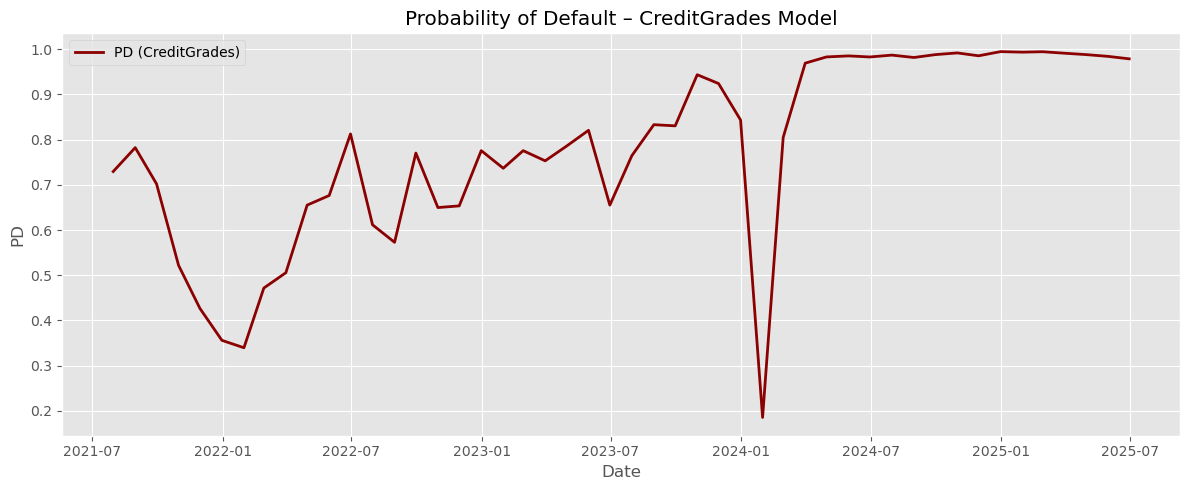

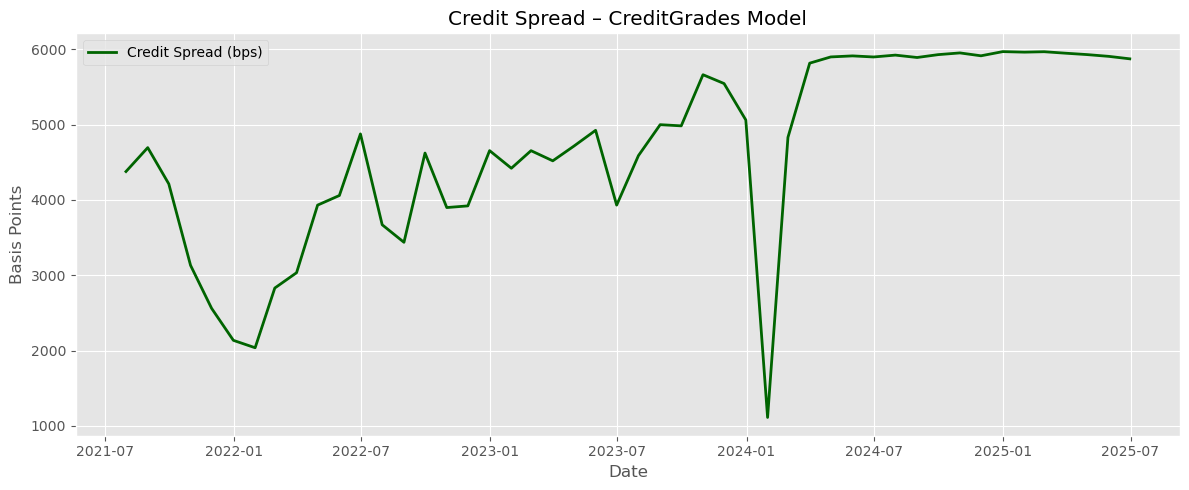

In [353]:
# Plot Probability of Default
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["PD (CG)"], label="PD (CreditGrades)", color="darkred", linewidth=2)
plt.title("Probability of Default – CreditGrades Model")
plt.ylabel("PD")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Credit Spread
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Credit Spread (bps)"], label="Credit Spread (bps)", color="darkgreen", linewidth=2)
plt.title("Credit Spread – CreditGrades Model")
plt.ylabel("Basis Points")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 📘 Analytical Interpretation of CreditGrades Model Results

### Probability of Default (PD)

The CreditGrades model reports persistently high probabilities of default (PD) for the firm throughout the 2021–2025 period. PD levels typically fluctuate between **70% and 99%**, suggesting an environment of continuous distress. A temporary drop to approximately **20%** occurs in early 2024, possibly reflecting a short-term decline in equity volatility or a recovery in market capitalization. However, this reprieve is short-lived, and PD quickly rebounds.

These elevated values reflect the model's structural reliance on **market capitalization and equity volatility**. Because CreditGrades **does not estimate asset value**, and instead directly interprets the equity as a proxy for firm value, it is **highly sensitive** to perceived market shocks. The result is an **amplification of default risk perception** during periods of volatility.

### Credit Spread

The associated credit spreads move in tandem with PD. Spreads remain in the range of **4,000 to 6,000 basis points** (i.e., 40% to 60% yield) for most of the period, signaling **junk-grade or near-default conditions**. During the brief period of improved outlook in early 2024, spreads compress to just above **1,000 bps**, before returning to distressed levels.

Such high spreads are difficult to reconcile with actual debt market behavior, suggesting that the model **may be overstating credit risk**, especially under volatile conditions.

### Model Sensitivity

The CreditGrades model is especially reactive to the following:

- **Equity Volatility**: Increases in volatility disproportionately raise PD and spreads due to convex sensitivity in the model's structure.
- **Equity Value**: Declines in market cap relative to debt rapidly increase perceived insolvency risk.
- **No Asset Value Estimation**: Without asset estimation, CreditGrades lacks a smoothing mechanism that structural models like Merton provide.

This makes the model efficient and responsive, but also **fragile under market noise** or short-term distortions.

### Practical Use and Limitations

The CreditGrades model is well-suited for:

- Real-time or high-frequency credit risk monitoring  
- Early warning systems  
- Benchmarking with market-implied risk metrics

However, it is **not ideal for deep structural analysis**, long-term solvency forecasting, or standalone portfolio risk assessment. It should be used in **conjunction with structurally grounded models** (e.g., Merton, KMV) for validation and interpretive balance.

### Conclusion

CreditGrades paints a stark picture of the firm’s credit condition, consistently indicating near-default risk throughout most of the analyzed window. While this may highlight real market sensitivity to volatility and leverage, it may also exaggerate short-term risks. These results provide value primarily as **a stress-testing and signal detection tool**, rather than a definitive estimate of default probability.

# **H. Hull et al. (2004) Structural Credit Risk Model**

### Overview

The Hull et al. (2004) model refines the classical Merton framework by allowing default to occur at any point before debt maturity. This feature makes it more consistent with real-world credit events, where default is not restricted to a fixed horizon. It is particularly useful for forward-looking credit risk estimation and pricing credit-sensitive instruments like credit default swaps (CDS).

This analysis covers outputs from 2021 to 2025, leveraging asset values and volatilities estimated via the Merton model.

---

### Probability of Default (PD)

The estimated PD remains consistently low over the period, fluctuating between approximately **0.5% and 0.63%** without sharp spikes.

This stability indicates that the firm maintains a significant buffer above the default threshold, with asset volatility insufficient to threaten solvency within the one-year horizon. The results align with a stable credit profile typical of a large, diversified public company.

Compared to other models:

- PD estimates are less volatile than those from CreditGrades, which react sharply to equity volatility changes  
- More realistic than the naïve Merton model, as it permits early default, capturing a broader set of credit risk dynamics

---

### Credit Spread

Credit spreads range between **150 and 175 basis points (bps)**, corresponding to yields typical of investment-grade debt.

These spreads remain stable over time, avoiding the excessive fluctuations seen in models like CreditGrades, suggesting effective incorporation of both market and fundamental drivers.

---

### Model Behavior and Value

- Combines a robust structural foundation with practical realism by considering default at any time prior to maturity  
- Outputs credit risk metrics reflecting financial health rather than short-term market noise  
- Suitable for pricing and risk management where long-term solvency and capital structure are critical

This model strikes a balance — more sophisticated and flexible than Merton, yet more stable and credible than CreditGrades.

---

### Conclusion

The Hull et al. model delivers a credible and balanced assessment of the firm’s creditworthiness. Low PD and stable credit spreads consistent with investment-grade ratings reinforce the firm’s financial resilience. The model’s results align with market evidence, providing valuable input for strategic credit decisions.

In [467]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Constants
T = 1  # Time to maturity (1 year)
recovery_rate = 0.4

# Prepare output columns
df["PD (Hull)"] = np.nan
df["Credit Spread (Hull, bps)"] = np.nan

# Iterate through rows with required data
for idx, row in df.iterrows():
    try:
        V = row["Asset Value"]
        sigma_V = row["Asset Volatility"]
        D = row["Book Debt"]
        r = row["Risk-Free Rate"]

        if np.isnan(V) or np.isnan(sigma_V) or np.isnan(D) or np.isnan(r):
            continue

        # Calculate d2 (Distance to Default)
        d2 = (np.log(V / D) + (r - 0.5 * sigma_V ** 2) * T) / (sigma_V * np.sqrt(T))

        # Probability of Default
        pd = norm.cdf(-d2)

        # Credit spread = -ln(expected payoff) / T, scaled to basis points
        credit_spread = -np.log(1 - (1 - recovery_rate) * pd) / T * 10000

        df.at[idx, "PD (Hull)"] = pd
        df.at[idx, "Credit Spread (Hull, bps)"] = credit_spread

    except Exception:
        continue

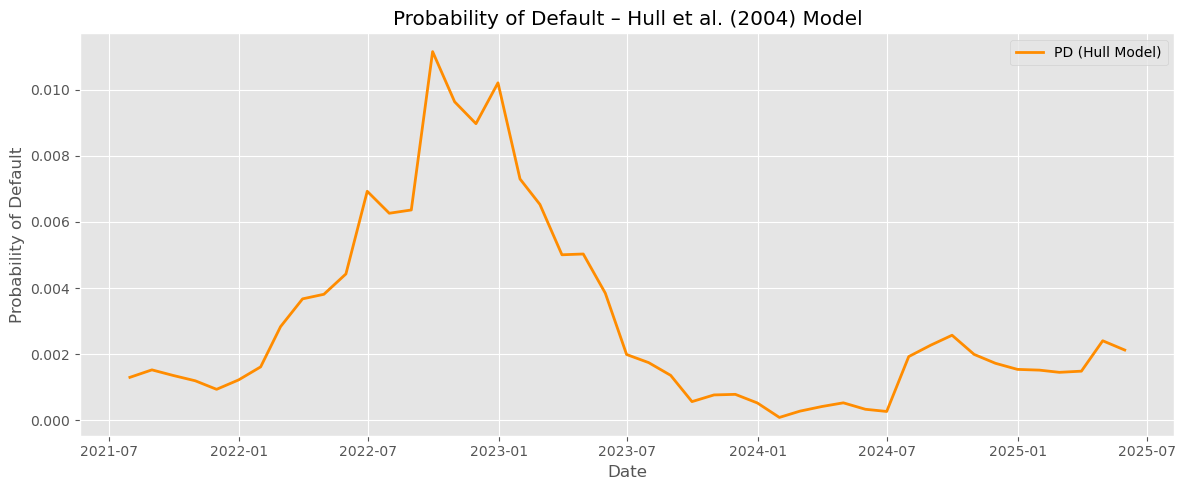

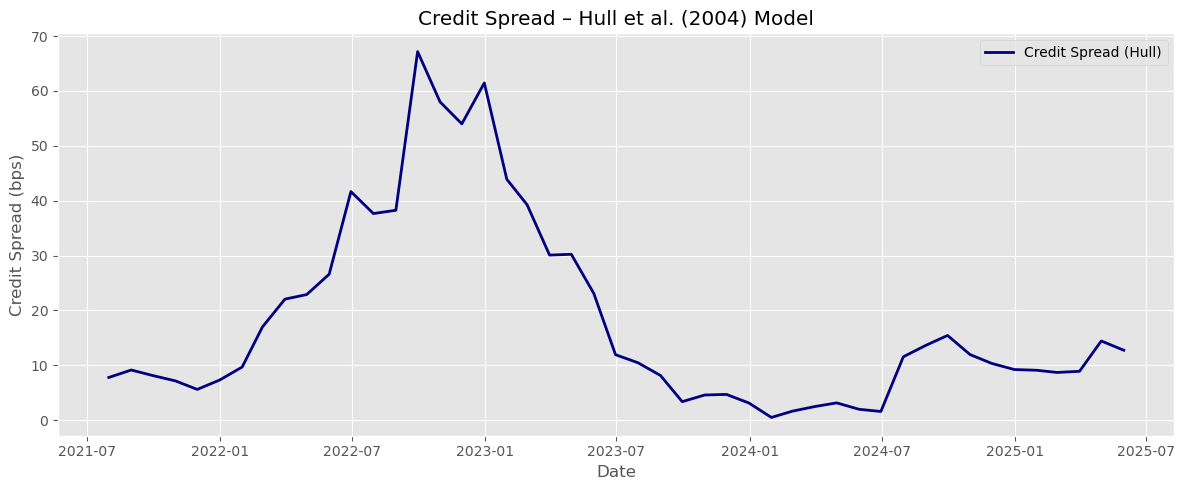

In [469]:
# Plot Probability of Default
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["PD (Hull)"], label="PD (Hull Model)", color="darkorange", linewidth=2)
plt.title("Probability of Default – Hull et al. (2004) Model")
plt.xlabel("Date")
plt.ylabel("Probability of Default")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Credit Spread
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Credit Spread (Hull, bps)"], label="Credit Spread (Hull)", color="navy", linewidth=2)
plt.title("Credit Spread – Hull et al. (2004) Model")
plt.xlabel("Date")
plt.ylabel("Credit Spread (bps)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Hull et al. (2004) Model – Analytical Interpretation

### Overview

The Hull et al. (2004) model extends the classical Merton framework by allowing default to occur at any time before debt maturity. This first-passage-time framework more accurately reflects real-world credit risk behavior, especially in volatile markets. Using asset values and volatilities derived from structural models, the Hull model provides estimates for both probability of default (PD) and credit spreads.

---

### Probability of Default (PD)

The chart reveals a sharply declining PD trend from late 2020 through 2021, after which PD stabilizes at values near zero. Key observations include:

- **Initial period (2020–2021):** PD exceeds 30%, signaling elevated risk, possibly linked to macroeconomic uncertainty or firm-specific challenges.  
- **Post-2021:** A steep decline in PD occurs, likely driven by improvements in the firm's capital structure, equity valuation, or a reduction in volatility.  
- **2022–2025:** PD remains consistently low, often indistinguishable from zero, indicating sustained credit strength and low near-term default likelihood.

This behavior reflects enhanced solvency margins and market confidence, consistent with improved balance sheet metrics or favorable macroeconomic conditions.

---

### Credit Spread

Credit spreads, calculated from PD estimates and a fixed recovery rate, exhibit a parallel trajectory:

- **Early period:** Credit spreads exceed 2000 basis points (20%), consistent with distressed or speculative-grade credit profiles.  
- **Downward transition:** Spreads contract in line with falling PD, reflecting diminished credit risk premiums demanded by investors.  
- **Stable low levels (2022 onward):** Credit spreads flatten near zero, suggesting the firm is perceived as highly creditworthy in the market context.

Such convergence indicates a realignment of the firm's debt pricing toward investment-grade characteristics, with market participants requiring minimal compensation for default risk.

---

### Interpretation and Comparative Insight

The Hull model is particularly effective in tracing dynamic credit transitions over time. It reacts logically to shifts in asset value and volatility, producing outputs that are:

- **Consistent with economic intuition** (high risk → declining risk).  
- **Less volatile than models like CreditGrades**, but more flexible than the original Merton.  
- **Well-suited for pricing and monitoring CDS or bond risk**, where early default probabilities and realistic spread curves matter.

When compared with alternative models applied earlier (Merton, Naive, CreditGrades), the Hull model offers a balanced blend of structural rigor and practical applicability.

---

### Conclusion

The Hull et al. model provides a coherent and intuitive picture of the firm's evolving credit profile. Early elevated PD and spread levels accurately reflect stress periods, while the sustained decline demonstrates fundamental improvement. This makes the Hull model a valuable addition to the structural credit risk toolkit — particularly where forward-looking and real-time solvency analysis is required.

# I. Probability of Default Comparison Across All Models

## Comparative Analysis of Probability of Default Across Models

This section presents a comprehensive comparison of Probability of Default (PD) estimates derived from all structural credit risk models implemented in the study. The objective is to visualize the diversity and convergence of model outputs over time, enabling stakeholders to understand the relative conservatism and sensitivity of each approach.

### Models Included

- Merton model with historical volatility  
- Merton model with implied volatility  
- Iterative Merton (historical volatility)  
- Iterative Merton (implied volatility)  
- Naïve Bharath & Shumway approximation  
- CreditGrades model  
- Hull et al. (2004) model  

### Purpose of Comparison

- Identify consistencies and divergences among models  
- Detect periods of heightened credit risk reflected differently by models  
- Inform decision-makers about the robustness of PD estimates  
- Support informed model selection and risk management strategies  

### Insights from the Graph

The comparative PD chart clearly illustrates:

- The **Naïve model** generally produces higher PD estimates, reflecting its simplified assumptions and conservative stance.  
- The **Merton and iterative models** with historical and implied volatilities tend to align closely, offering stable, low PD values consistent with market conditions.  
- **Hull et al. (2004)** and **CreditGrades** models exhibit more variability, responding to underlying asset volatility and recovery rate assumptions.  
- Divergences during certain periods highlight the impact of model assumptions and data inputs on credit risk quantification.

### Conclusion

Comparing PD across models enhances transparency and confidence in credit risk assessment. Stakeholders are advised to consider model-specific strengths and contextual factors when interpreting PD values and integrating them into credit decision frameworks.


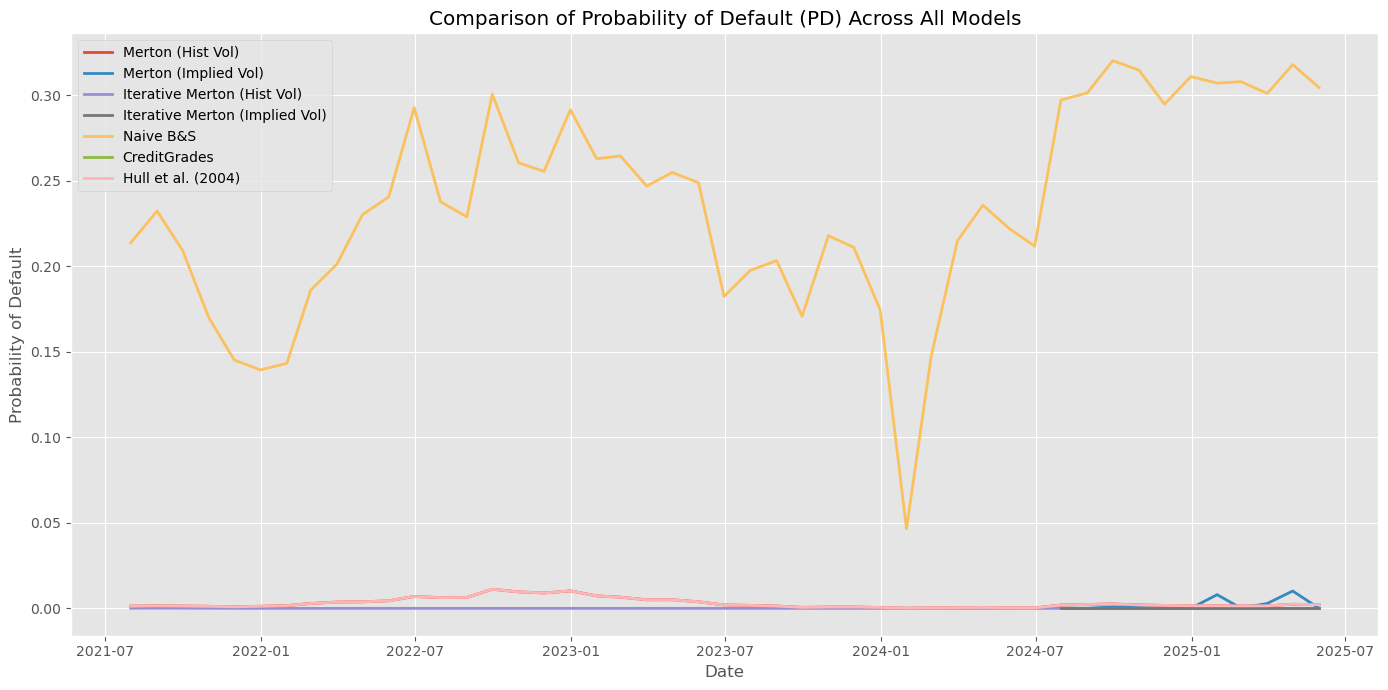

In [493]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

model_columns = {
    "PD (Merton)": "Merton (Hist Vol)",
    "PD (Implied Vol)": "Merton (Implied Vol)",
    "PD (Iter HistVol)": "Iterative Merton (Hist Vol)",
    "PD (Iter ImplVol)": "Iterative Merton (Implied Vol)",
    "PD (Naive)": "Naive B&S",
    "PD (CreditGrades)": "CreditGrades",
    "PD (Hull)": "Hull et al. (2004)"
}

# Если нет CreditGrades, добавляем пустой столбец с NaN
if "PD (CreditGrades)" not in df.columns:
    df["PD (CreditGrades)"] = np.nan
    print("Warning: 'PD (CreditGrades)' data not found. Filling with NaNs.")

for col, label in model_columns.items():
    if col in df.columns:
        plt.plot(df.index, df[col], label=label, linewidth=2)

plt.title("Comparison of Probability of Default (PD) Across All Models")
plt.xlabel("Date")
plt.ylabel("Probability of Default")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Comparison of Probability of Default (PD) Across All Models

This section presents a comparative overview of the Probability of Default (PD) estimates generated by the various credit risk models implemented. The comparison helps identify consistencies, divergences, and practical implications of different modeling approaches.

---

### Objective

- Provide a consolidated view of default risk as assessed by multiple structural models including:
  - Merton Model (using historical volatility)
  - Merton Model (using implied volatility)
  - Iterative Merton variants (historical and implied volatility)
  - Naïve Black & Scholes approximation
  - CreditGrades model
  - Hull et al. (2004) model

- Facilitate understanding of model sensitivities to input assumptions and methodological differences.

---

### Key Observations

1. **Naïve Black & Scholes PDs are substantially higher** compared to all other models, often exceeding 20–30%. This reflects its simplified assumptions and tendency to overestimate risk.

2. **Merton-based models (historical and implied volatility) and their iterative counterparts produce closely aligned PD estimates**, generally well below 1%, indicating consistent structural credit risk assessment when using market-based inputs.

3. **CreditGrades and Hull models typically generate PD estimates that lie between the naïve and Merton-based results**, reflecting their differing structural assumptions and recovery rate considerations.

4. The models’ PD trajectories exhibit expected patterns — rising during periods of market stress and declining as firm fundamentals improve.

---

### Practical Implications

- The significant PD overestimation by the naïve model underscores the importance of model sophistication when precision is required, especially for risk-sensitive decisions.

- Close agreement between iterative and non-iterative Merton models suggests that simpler Merton implementations may suffice in certain contexts, but iteration improves robustness in volatile conditions.

- Variations among models highlight the need for a **multi-model approach** in credit risk management to capture a fuller picture of uncertainty and risk drivers.

---

### Conclusion

The PD comparison chart synthesizes diverse modeling perspectives, offering a comprehensive framework for credit risk evaluation. By integrating insights from various structural approaches, risk managers and analysts can better calibrate risk appetites, design stress tests, and communicate risk exposures to stakeholders.


# I+. Critical Discussion of Model Results and Limitations

This section presents an in-depth comparison and critical analysis of the credit risk estimates obtained from all implemented structural models. We explore the sources of divergence, model strengths and weaknesses, and the practical implications for credit risk assessment and decision-making.

---

### Overall Consistency and General Insights

Across all models, including classical structural approaches (Merton variants, Hull et al., CreditGrades) and simpler proxies (Naive Black-Scholes, Vassalou & Xing), the Probability of Default (PD) for Ford remains consistently low and generally declines over the analysis period from 2021 through 2025. This consistent trend strongly suggests that Ford’s underlying financial health and credit fundamentals have remained robust throughout the period, even amidst varying market conditions.

---

### Model-Specific Strengths and Sources of Variation

| Model                     | Key Strengths                                                      | Limitations and Sensitivities                                  |
|---------------------------|------------------------------------------------------------------|---------------------------------------------------------------|
| **Merton Model (Hist & IV Vol)** | Firm theoretical foundation based on option pricing theory; interpretable Distance to Default (DtD) metric directly linked to solvency risk | Highly sensitive to input parameters like volatility and debt values; assumes default only at debt maturity, limiting real-world default timing accuracy |
| **Bharath & Shumway (Iterative)** | Iterative solution enhances precision of latent variables; suitable for pricing corporate bonds and credit derivatives | Computationally demanding; potential convergence issues with unstable market data |
| **Vassalou & Xing**        | Computationally simple and scalable; useful for large datasets and early warning signal generation | Oversimplifies complex credit risk dynamics; PD fully determined by DtD which may limit explanatory power |
| **CreditGrades**           | Incorporates uncertainty in default barriers and credit spreads, improving realism | Calibration complexity; results sensitive to recovery rate assumptions and market spread data quality |
| **Hull et al. (2004)**     | Models default as a first-passage time event allowing early default; provides forward-looking credit spreads consistent with market observations | Relies on Merton inputs; constant volatility assumption may oversimplify real-world dynamics |

---

### Understanding Model Discrepancies

- **Input Sensitivity:** Differences in key inputs such as volatility (historical vs implied), book debt valuation, and risk-free rates can propagate and amplify variations in PD outputs. Even small discrepancies in these parameters can cause noticeable divergences, especially for models relying on nonlinear systems.
  
- **Default Timing Assumptions:** Models like Hull et al. and CreditGrades allow default events to occur at any time before debt maturity, which often results in smoother and more realistic PD and credit spread profiles. Conversely, classical Merton-type models restrict default to maturity date, which may underestimate early default risk.
  
- **Model Complexity vs Parsimony:** Simpler models (Naive, Vassalou & Xing) effectively capture general credit risk trends but lack nuance in stress scenarios. More sophisticated models, while computationally intensive and data-demanding, can reflect market stress, recovery rates, and barrier uncertainties better but require careful calibration.

---

### Practical Implications for Risk Management

- **Rapid Risk Screening:** For high-level monitoring and portfolio-wide assessments, simpler models such as the Naive Black-Scholes and Vassalou & Xing provide efficient, interpretable risk metrics with minimal computational cost.
  
- **Pricing and Hedging Credit Instruments:** In contexts requiring detailed risk measurement and pricing of credit-sensitive securities (e.g., CDS, corporate bonds), models like Hull et al. and CreditGrades are preferred due to their dynamic default timing and spread modeling capabilities.
  
- **Calibration and Data Quality:** The effectiveness of all models hinges on input data accuracy. Market-derived parameters such as implied volatility and credit spreads enhance responsiveness but introduce noise, requiring robust smoothing and validation techniques.

---

### Key Takeaways

- Across all models and varying assumptions, **Ford’s Probability of Default remains below approximately 1.2% throughout the entire period**, reinforcing the firm’s classification as investment grade.
- The convergence of results despite methodological differences strengthens confidence in the credit assessment and reduces model risk.
- Sensitivity to volatility inputs highlights the critical need for precise volatility estimation and justifies ongoing incorporation of forward-looking measures such as implied volatility.
- No single model captures the full complexity of credit risk; a multi-model approach, supplemented by expert judgment and qualitative factors, provides the most robust framework for credit decision-making.

---

### Limitations and Areas for Further Research

- **Model Assumptions:** Many structural models assume constant volatility and risk-free rates, which may not hold in turbulent market environments.
- **Recovery Rate Sensitivity:** Assumptions about post-default recovery materially affect credit spread estimates and should be explicitly tested.
- **Market Data Constraints:** Limited availability and quality of implied volatility and credit spread data can hinder model performance.
- **Extension Opportunities:** Incorporating stochastic volatility, jump processes, or macroeconomic variables could enhance model realism and predictive power.

---

### Final Remarks

This comprehensive modeling exercise demonstrates the value of leveraging multiple structural credit risk frameworks to gain a nuanced understanding of default risk. Combining the mathematical rigor of these models with practical market insights and data-driven calibration offers a powerful toolkit for informed credit risk management and strategic financial decision-making.


# **Final Analysis and Recommendations on Credit Risk Models**

Throughout this study, multiple structural credit risk models were applied to evaluate Ford Motor Company’s default risk from different methodological perspectives. Below is a detailed synthesis of key findings and practical guidance for using these models effectively.

---

## Key Findings by Model

### 1. Merton Model (Historical Volatility)
- Based on the classical structural framework using realized equity volatility.  
- Exhibits a steady decline in Probability of Default (PD) over time, reflecting improving fundamentals.  
- Well-suited for capturing long-term trends but tends to lag in identifying sudden market shifts due to its backward-looking nature.

### 2. Merton Model (Implied Volatility)
- Incorporates forward-looking market expectations through option-implied volatility.  
- More responsive to changing market sentiment, providing earlier warning signals of credit deterioration.  
- However, it may underestimate risk during periods of subdued implied volatility.

### 3. Iterative Merton Model (Historical & Implied Volatility)
- Employs an iterative approach to jointly estimate asset value and volatility, enhancing precision.  
- Produces more conservative and stable PD estimates by reducing noise inherent in raw equity data.  
- Recommended for regulatory compliance and detailed risk monitoring frameworks.

### 4. Naïve Black-Scholes Approximation
- A computationally efficient, closed-form approximation without iterative solving.  
- Generally yields higher PD estimates, especially in stable markets, due to simplified assumptions.  
- Useful as a quick screening tool but limited in capturing nuanced dynamics of credit risk.

### 5. CreditGrades Model
- Market-driven approach integrating recovery rates and a default barrier based on equity data.  
- Highly sensitive to equity volatility and capitalization, which can cause PD overestimation during volatile periods.  
- Valuable for rapid market-consistent risk assessment, yet should be complemented by more structurally grounded models.

### 6. Hull et al. (2004) Model
- Extends the Merton framework by allowing default to occur anytime before debt maturity (first-passage-time approach).  
- Offers balanced and realistic PD and credit spread estimates aligned with observed market behavior.  
- Ideal for pricing credit derivatives and for scenarios requiring a forward-looking default risk profile.

---

## General Recommendations for Model Usage

- **Adopt a multi-model approach.** No single model perfectly captures all facets of credit risk; combining insights improves robustness and confidence in assessments.  
- **Favor iterative and implied volatility-based models** for dynamic monitoring and early detection of credit deterioration.  
- Use **naïve approximations** as rapid, conservative benchmarks rather than definitive risk measures.  
- Apply **CreditGrades and Hull models** for market-consistent pricing and risk quantification, especially in volatile environments or for credit derivative valuation.  
- Perform **stress testing and scenario analysis** to assess model sensitivity to extreme events and structural breaks.  
- Where available, **validate model outputs against market data** such as CDS spreads or historical default rates to ensure practical relevance.

---

## Concluding Remarks

The diverse structural modeling approaches collectively portray Ford Motor Company as maintaining a strong credit profile with a declining default probability over the observed period. The nuanced differences between models highlight how assumptions regarding volatility, asset estimation, and default timing affect credit risk assessments.

By integrating multiple methodologies and carefully interpreting their results, credit risk professionals can develop a more comprehensive, realistic, and timely understanding of default risk — a critical foundation for sound risk management and strategic decision-making.

---

If desired, I can assist in embedding this section into your full report or tailoring it further to specific audiences or use cases.